In [1]:
import json
import matplotlib.pyplot as plt
import torch

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image
from PIL import Image

import numpy as np
import matplotlib.patches as patches
from torchvision import transforms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchmetrics.detection.map import MeanAveragePrecision

In [2]:
import pycocotools

In [3]:
# imports from local lib files
import utils
import transforms
import coco_eval
from engine import train_one_epoch, evaluate

Example of data in annotation files

In [4]:
output_path = 'output'
img_folder = 'eccv_18_all_images_sm'

cis_test_ann_path = 'eccv_18_annotation_files/cis_test_annotations.json'
cis_val_ann_path = 'eccv_18_annotation_files/cis_val_annotations.json'
train_ann_path = 'eccv_18_annotation_files/train_annotations.json'
trans_test_ann_path = 'eccv_18_annotation_files/trans_test_annotations.json'
trans_val_ann_path = 'eccv_18_annotation_files/trans_val_annotations.json'

Number of images per split

In [5]:
cis_test_ann = json.load(open(cis_test_ann_path))
cis_val_ann = json.load(open(cis_val_ann_path))
train_ann= json.load(open(train_ann_path))
trans_test_ann = json.load(open(trans_test_ann_path))
trans_val_ann = json.load(open(trans_val_ann_path))

In [6]:
print(len(cis_test_ann['images']))
print(len(cis_val_ann['images']))
print(len(train_ann['images']))
print(len(trans_test_ann['images']))
print(len(trans_val_ann['images']))

15827
3484
13553
23275
1725


In [7]:
trans_val_ann.keys()

dict_keys(['info', 'categories', 'images', 'annotations'])

In [8]:
trans_val_ann['info']

{'contributor': 'Sara Beery',
 'date_created': '2018-07-03 18:34:36.573636',
 'version': 'Caltech Camera Traps - ECCV18',
 'description': 'Database of camera trap images collected from the NPS and the USGS with help from Justin Brown and Erin Boydston',
 'year': 2018}

In [9]:
trans_val_ann['categories']

[{'id': 6, 'name': 'bobcat'},
 {'id': 1, 'name': 'opossum'},
 {'id': 30, 'name': 'empty'},
 {'id': 9, 'name': 'coyote'},
 {'id': 3, 'name': 'raccoon'},
 {'id': 11, 'name': 'bird'},
 {'id': 8, 'name': 'dog'},
 {'id': 16, 'name': 'cat'},
 {'id': 5, 'name': 'squirrel'},
 {'id': 10, 'name': 'rabbit'},
 {'id': 7, 'name': 'skunk'},
 {'id': 99, 'name': 'rodent'},
 {'id': 21, 'name': 'badger'},
 {'id': 34, 'name': 'deer'},
 {'id': 33, 'name': 'car'},
 {'id': 51, 'name': 'fox'}]

In [10]:
trans_val_ann['annotations'][0]

{'image_id': '58df680b-23d2-11e8-a6a3-ec086b02610b',
 'category_id': 6,
 'bbox': [1123.7375892857142,
  787.8743750000001,
  284.6749107142857,
  244.2854464285715],
 'id': '19220'}

## Horizontal flip debugging

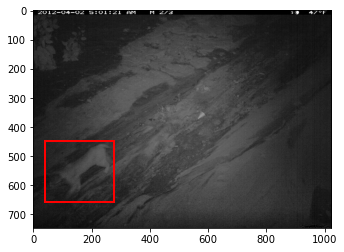

In [11]:
i = 500

boxes = [trans_val_ann['annotations'][j]['bbox'] for j in range(len(trans_val_ann['annotations'])) 
         if trans_val_ann['annotations'][j]['image_id']==trans_val_ann['images'][i]['id'] 
         and 'bbox' in trans_val_ann['annotations'][j].keys()]

img_path = os.path.join('eccv_18_all_images_sm', trans_val_ann['images'][i]['file_name']) # to change

image = read_image(img_path)

fig, ax = plt.subplots()
ax.imshow(image[0].squeeze(),cmap="gray")

scale_x = image.shape[2] / trans_val_ann['images'][i]['width'] 
scale_y = image.shape[1] / trans_val_ann['images'][i]['height']

boxes = torch.as_tensor(boxes)

for i in range(boxes.shape[0]):
    boxes[i][0] = torch.round(boxes[i][0] * scale_x)
    boxes[i][1] = torch.round(boxes[i][1] * scale_y)
    boxes[i][2] = torch.round(boxes[i][2] * scale_x)
    boxes[i][3] = torch.round(boxes[i][3] * scale_y)

    boxes[i][2] = boxes[i][0] + boxes[i][2]
    boxes[i][3] = boxes[i][1] + boxes[i][3]

target = {}
target["boxes"] = boxes

rect = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2]-boxes[0][0], 
                         boxes[0][3]-boxes[0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [12]:
image = Image.open(img_path).convert("RGB")
#image=conv(image)

In [13]:
image.size

(1024, 747)

In [14]:
conv = torchvision.transforms.ToTensor()

In [15]:
width, height = image.size[0], image.size[1]

In [16]:
width

1024

In [17]:
height

747

In [18]:
image_new = conv(image)

In [19]:
print(image_new.shape)

torch.Size([3, 747, 1024])


## Utils

In [20]:
# In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

import transforms as T   # from git hub repo

data_transform = {'train': T.RandomHorizontalFlip(0.5)}

In [21]:
def get_img_with_bbox(file_path):
  
    # returns a list with the idx of images with at least one bounding box (img_wbbox) and a list with the number of bbox for each valid image (num_bbox)
    file = json.load(open(file_path))
    img_wbbox=[]
    num_bbox=[]

    for i in range(len(file['images'])):
        bboxes= [file['annotations'][j]['bbox'] for j in range(len(file['annotations'])) if file['annotations'][j]['image_id']==file['images'][i]['id'] and 'bbox' in file['annotations'][j].keys()]

        if len(bboxes)!=0:
            img_wbbox.append(i)

            num_bbox.append(len(bboxes))

    return img_wbbox, num_bbox

In [22]:
class CustomImageDataset(Dataset):
    def __init__(self, label_path, img_dir, valid_img, transform= None, target_transform=None):
        self.label_file = json.load(open(label_path))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.valid_img= valid_img

    def __len__(self):
        return len(self.valid_img)

    def __getitem__(self, idx):
        
        idx=self.valid_img[idx] # consider only images with bbox annotations
        img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
        image = read_image(img_path)

        conv=torchvision.transforms.ToTensor()
        #if image.shape[0]==1:
        # some images have only one channel, we convert them to rgb
        image = Image.open(img_path).convert("RGB")
        image=conv(image)

        boxes= [self.label_file['annotations'][j]['bbox'] for j in range(len(self.label_file['annotations'])) if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        label= [self.label_file['annotations'][j]['category_id'] for j in range(len(self.label_file['annotations'])) if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

        # transform bbox coords to adjust for resizing
        scale_x=image.shape[2]/self.label_file['images'][idx]['width'] 
        scale_y=image.shape[1]/self.label_file['images'][idx]['height']

        boxes=torch.as_tensor(boxes)
        for i in range(boxes.shape[0]):
            boxes[i][0]=torch.round(boxes[i][0]*scale_x)
            boxes[i][1]=torch.round(boxes[i][1]*scale_y)
            boxes[i][2]=torch.round(boxes[i][2]*scale_x)
            boxes[i][3]=torch.round(boxes[i][3]*scale_y)

            boxes[i][2]=boxes[i][0]+boxes[i][2] # to transform to pytorch bbox format
            boxes[i][3]=boxes[i][1]+boxes[i][3]

            #boxes[i][0]*=scale_x
            #boxes[i][1]*=scale_y
            #boxes[i][2]*=scale_x
            #boxes[i][3]*=scale_y

        label=torch.as_tensor(label)
        label=torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["image_id"] = image_id
        target['area']=area
        target['iscrowd']=iscrowd

        # TO DO : resize all to same size

        if self.transform:
            # transform image AND target
            image, target = self.transform(image, target)
        if self.target_transform:
            label = self.target_transform(label)

        return image, target


Example of use

In [212]:
# get the images bounding boxes *takes about 25sec*
train_valid_img,_ = get_img_with_bbox(train_ann_path)
cis_val_valid_img,_ = get_img_with_bbox(cis_val_ann_path)

In [213]:
training_data = CustomImageDataset(train_ann_path, img_folder, train_valid_img)
valid_data = CustomImageDataset(cis_val_ann_path, img_folder, cis_val_valid_img)

train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

# In paper : ' We use a batch size of 1'

Target (Bbox) batch shape: torch.Size([1, 4])
Target (category) batch shape: torch.Size([1])
Label: animal


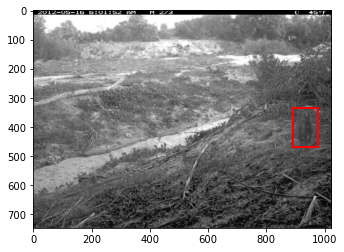

In [218]:
train_features, train_labels = next(iter(train_dataloader))
#print(f"Feature batch shape: {train_features.size()}")
print(f"Target (Bbox) batch shape: {train_labels[0]['boxes'].size()}")
print(f"Target (category) batch shape: {train_labels[0]['labels'].size()}")

img = train_features[0][0].squeeze()
label = train_labels[0]['labels']
label_categ='animal'

if label[0]==0:
    label_categ='background'

fig, ax = plt.subplots()
ax.imshow(img,cmap="gray")
rect = patches.Rectangle((train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][1]), train_labels[0]['boxes'][0][2]-train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][3]-train_labels[0]['boxes'][0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
print(f"Label: {label_categ}")

## Horizontal flip debugging p2

In [219]:
trans = data_transform['train']
img2, target2 = trans(image, target)

fig, ax = plt.subplots()
ax.imshow(img2, cmap="gray")

rect = patches.Rectangle((target2['boxes'][0][0], target2['boxes'][0][1]), 
                         target2['boxes'][0][2] - target2['boxes'][0][0], 
                         target2['boxes'][0][3] - target2['boxes'][0][1], 
                         linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

TypeError: img should be PIL Image. Got <class 'list'>

## Pre-trained model

In [27]:
# Inspired from https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=YjNHjVMOyYlH

In [28]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

# like in the paper
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

In [30]:
# train_valid_img,_ = get_img_with_bbox(train_ann_path)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

In [31]:
trans_val_valid_img,_ = get_img_with_bbox(trans_val_ann_path)   # takes about 1min to run on train data
trans_valid_data = CustomImageDataset(trans_val_ann_path,img_folder, trans_val_valid_img)
trans_valid_dataloader = DataLoader(trans_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [32]:
cis_val_valid_img,_ = get_img_with_bbox(cis_val_ann_path)   # takes about 1min to run on train data
cis_valid_data = CustomImageDataset(cis_val_ann_path,img_folder, cis_val_valid_img)
cis_valid_dataloader = DataLoader(cis_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [221]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080 Ti'

In [35]:
# TRAIN

all_train_logs = []
all_trans_valid_logs = []
all_cis_valid_logs = []

num_epochs = 30

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_logs = train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=100)
    all_train_logs.append(train_logs)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset

    for images, targets in trans_valid_dataloader: # can do batch of 10 prob.
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            trans_loss_dict = model(images, targets)
            trans_loss_dict = [{k: loss.to('cpu')} for k, loss in trans_loss_dict.items()]
            all_trans_valid_logs.append(trans_loss_dict)


    for images, targets in cis_valid_dataloader: # can do batch of 10 prob.
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            cis_loss_dict = model(images, targets)
            cis_loss_dict = [{k: loss.to('cpu')} for k, loss in cis_loss_dict.items()]
            all_cis_valid_logs.append(cis_loss_dict)

C:\Users\kevin\miniconda3\envs\animals\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [    0/12099]  eta: 10:57:23  lr: 0.000001  loss: 0.7922 (0.7922)  loss_classifier: 0.6583 (0.6583)  loss_box_reg: 0.1317 (0.1317)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 3.2601  data: 0.0325  max mem: 519
Epoch: [0]  [  100/12099]  eta: 0:30:34  lr: 0.000031  loss: 0.3393 (0.5606)  loss_classifier: 0.1813 (0.3977)  loss_box_reg: 0.1124 (0.1268)  loss_objectness: 0.0020 (0.0288)  loss_rpn_box_reg: 0.0039 (0.0073)  time: 0.1128  data: 0.0310  max mem: 523
Epoch: [0]  [  200/12099]  eta: 0:26:08  lr: 0.000061  loss: 0.2295 (0.4243)  loss_classifier: 0.0977 (0.2646)  loss_box_reg: 0.1076 (0.1254)  loss_objectness: 0.0083 (0.0269)  loss_rpn_box_reg: 0.0025 (0.0075)  time: 0.1123  data: 0.0295  max mem: 523
Epoch: [0]  [  300/12099]  eta: 0:24:49  lr: 0.000091  loss: 0.2376 (0.3689)  loss_classifier: 0.1046 (0.2109)  loss_box_reg: 0.1187 (0.1205)  loss_objectness: 0.0112 (0.0298)  loss_rpn_box_reg: 0.0030 (0.0077)  time: 0.1150  data: 0.0313  

Epoch: [0]  [ 3300/12099]  eta: 0:16:32  lr: 0.000300  loss: 0.1227 (0.1926)  loss_classifier: 0.0455 (0.0731)  loss_box_reg: 0.0465 (0.0782)  loss_objectness: 0.0067 (0.0336)  loss_rpn_box_reg: 0.0019 (0.0077)  time: 0.1078  data: 0.0274  max mem: 523
Epoch: [0]  [ 3400/12099]  eta: 0:16:20  lr: 0.000300  loss: 0.1225 (0.1916)  loss_classifier: 0.0490 (0.0726)  loss_box_reg: 0.0632 (0.0777)  loss_objectness: 0.0025 (0.0337)  loss_rpn_box_reg: 0.0020 (0.0077)  time: 0.1097  data: 0.0288  max mem: 523
Epoch: [0]  [ 3500/12099]  eta: 0:16:08  lr: 0.000300  loss: 0.1369 (0.1905)  loss_classifier: 0.0498 (0.0721)  loss_box_reg: 0.0560 (0.0772)  loss_objectness: 0.0113 (0.0336)  loss_rpn_box_reg: 0.0016 (0.0076)  time: 0.1077  data: 0.0283  max mem: 523
Epoch: [0]  [ 3600/12099]  eta: 0:15:56  lr: 0.000300  loss: 0.1455 (0.1893)  loss_classifier: 0.0402 (0.0714)  loss_box_reg: 0.0573 (0.0767)  loss_objectness: 0.0053 (0.0336)  loss_rpn_box_reg: 0.0039 (0.0076)  time: 0.1101  data: 0.0290  m

Epoch: [0]  [ 6600/12099]  eta: 0:10:11  lr: 0.000300  loss: 0.1402 (0.1706)  loss_classifier: 0.0411 (0.0617)  loss_box_reg: 0.0518 (0.0680)  loss_objectness: 0.0097 (0.0331)  loss_rpn_box_reg: 0.0032 (0.0078)  time: 0.1083  data: 0.0275  max mem: 523
Epoch: [0]  [ 6700/12099]  eta: 0:09:59  lr: 0.000300  loss: 0.1138 (0.1701)  loss_classifier: 0.0295 (0.0614)  loss_box_reg: 0.0450 (0.0678)  loss_objectness: 0.0103 (0.0331)  loss_rpn_box_reg: 0.0036 (0.0078)  time: 0.1079  data: 0.0270  max mem: 523
Epoch: [0]  [ 6800/12099]  eta: 0:09:48  lr: 0.000300  loss: 0.1385 (0.1699)  loss_classifier: 0.0435 (0.0613)  loss_box_reg: 0.0671 (0.0677)  loss_objectness: 0.0059 (0.0331)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1099  data: 0.0286  max mem: 523
Epoch: [0]  [ 6900/12099]  eta: 0:09:37  lr: 0.000300  loss: 0.1442 (0.1698)  loss_classifier: 0.0499 (0.0612)  loss_box_reg: 0.0626 (0.0676)  loss_objectness: 0.0068 (0.0333)  loss_rpn_box_reg: 0.0032 (0.0078)  time: 0.1107  data: 0.0289  m

Epoch: [0]  [ 9900/12099]  eta: 0:04:03  lr: 0.000300  loss: 0.1089 (0.1634)  loss_classifier: 0.0394 (0.0576)  loss_box_reg: 0.0552 (0.0645)  loss_objectness: 0.0108 (0.0333)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1105  data: 0.0286  max mem: 523
Epoch: [0]  [10000/12099]  eta: 0:03:52  lr: 0.000300  loss: 0.1152 (0.1634)  loss_classifier: 0.0302 (0.0576)  loss_box_reg: 0.0500 (0.0645)  loss_objectness: 0.0057 (0.0334)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1092  data: 0.0281  max mem: 523
Epoch: [0]  [10100/12099]  eta: 0:03:41  lr: 0.000300  loss: 0.1128 (0.1631)  loss_classifier: 0.0372 (0.0574)  loss_box_reg: 0.0499 (0.0645)  loss_objectness: 0.0062 (0.0334)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1102  data: 0.0292  max mem: 523
Epoch: [0]  [10200/12099]  eta: 0:03:30  lr: 0.000300  loss: 0.1611 (0.1630)  loss_classifier: 0.0571 (0.0574)  loss_box_reg: 0.0590 (0.0644)  loss_objectness: 0.0225 (0.0334)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1079  data: 0.0271  m

Epoch: [1]  [ 1000/12099]  eta: 0:20:13  lr: 0.000300  loss: 0.1380 (0.1448)  loss_classifier: 0.0508 (0.0481)  loss_box_reg: 0.0476 (0.0558)  loss_objectness: 0.0092 (0.0335)  loss_rpn_box_reg: 0.0031 (0.0074)  time: 0.1084  data: 0.0275  max mem: 3753
Epoch: [1]  [ 1100/12099]  eta: 0:20:01  lr: 0.000300  loss: 0.1288 (0.1433)  loss_classifier: 0.0290 (0.0475)  loss_box_reg: 0.0367 (0.0553)  loss_objectness: 0.0069 (0.0330)  loss_rpn_box_reg: 0.0030 (0.0074)  time: 0.1070  data: 0.0264  max mem: 3753
Epoch: [1]  [ 1200/12099]  eta: 0:19:50  lr: 0.000300  loss: 0.1492 (0.1440)  loss_classifier: 0.0326 (0.0475)  loss_box_reg: 0.0458 (0.0555)  loss_objectness: 0.0214 (0.0335)  loss_rpn_box_reg: 0.0043 (0.0075)  time: 0.1094  data: 0.0284  max mem: 3753
Epoch: [1]  [ 1300/12099]  eta: 0:19:39  lr: 0.000300  loss: 0.1073 (0.1432)  loss_classifier: 0.0356 (0.0472)  loss_box_reg: 0.0540 (0.0556)  loss_objectness: 0.0080 (0.0330)  loss_rpn_box_reg: 0.0043 (0.0074)  time: 0.1088  data: 0.0273

Epoch: [1]  [ 4300/12099]  eta: 0:14:14  lr: 0.000300  loss: 0.1379 (0.1426)  loss_classifier: 0.0394 (0.0468)  loss_box_reg: 0.0429 (0.0559)  loss_objectness: 0.0060 (0.0323)  loss_rpn_box_reg: 0.0022 (0.0076)  time: 0.1094  data: 0.0283  max mem: 3753
Epoch: [1]  [ 4400/12099]  eta: 0:14:03  lr: 0.000300  loss: 0.1356 (0.1427)  loss_classifier: 0.0350 (0.0467)  loss_box_reg: 0.0452 (0.0559)  loss_objectness: 0.0175 (0.0324)  loss_rpn_box_reg: 0.0046 (0.0076)  time: 0.1096  data: 0.0285  max mem: 3753
Epoch: [1]  [ 4500/12099]  eta: 0:13:52  lr: 0.000300  loss: 0.1056 (0.1426)  loss_classifier: 0.0330 (0.0467)  loss_box_reg: 0.0424 (0.0559)  loss_objectness: 0.0058 (0.0323)  loss_rpn_box_reg: 0.0011 (0.0076)  time: 0.1104  data: 0.0294  max mem: 3753
Epoch: [1]  [ 4600/12099]  eta: 0:13:41  lr: 0.000300  loss: 0.1105 (0.1425)  loss_classifier: 0.0285 (0.0467)  loss_box_reg: 0.0407 (0.0559)  loss_objectness: 0.0047 (0.0324)  loss_rpn_box_reg: 0.0021 (0.0076)  time: 0.1093  data: 0.0279

Epoch: [1]  [ 7600/12099]  eta: 0:08:12  lr: 0.000300  loss: 0.1430 (0.1423)  loss_classifier: 0.0448 (0.0461)  loss_box_reg: 0.0517 (0.0555)  loss_objectness: 0.0158 (0.0329)  loss_rpn_box_reg: 0.0048 (0.0078)  time: 0.1088  data: 0.0274  max mem: 3753
Epoch: [1]  [ 7700/12099]  eta: 0:08:01  lr: 0.000300  loss: 0.1323 (0.1424)  loss_classifier: 0.0407 (0.0461)  loss_box_reg: 0.0643 (0.0555)  loss_objectness: 0.0061 (0.0330)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1087  data: 0.0275  max mem: 3753
Epoch: [1]  [ 7800/12099]  eta: 0:07:50  lr: 0.000300  loss: 0.1189 (0.1423)  loss_classifier: 0.0328 (0.0461)  loss_box_reg: 0.0511 (0.0555)  loss_objectness: 0.0018 (0.0329)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1085  data: 0.0276  max mem: 3753
Epoch: [1]  [ 7900/12099]  eta: 0:07:39  lr: 0.000300  loss: 0.0980 (0.1422)  loss_classifier: 0.0289 (0.0460)  loss_box_reg: 0.0431 (0.0554)  loss_objectness: 0.0038 (0.0329)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1098  data: 0.0282

Epoch: [1]  [10900/12099]  eta: 0:02:11  lr: 0.000300  loss: 0.1498 (0.1423)  loss_classifier: 0.0407 (0.0458)  loss_box_reg: 0.0616 (0.0556)  loss_objectness: 0.0044 (0.0331)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1091  data: 0.0270  max mem: 3753
Epoch: [1]  [11000/12099]  eta: 0:02:00  lr: 0.000300  loss: 0.0974 (0.1422)  loss_classifier: 0.0345 (0.0458)  loss_box_reg: 0.0315 (0.0556)  loss_objectness: 0.0027 (0.0331)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1085  data: 0.0275  max mem: 3753
Epoch: [1]  [11100/12099]  eta: 0:01:49  lr: 0.000300  loss: 0.1198 (0.1422)  loss_classifier: 0.0458 (0.0458)  loss_box_reg: 0.0531 (0.0556)  loss_objectness: 0.0121 (0.0330)  loss_rpn_box_reg: 0.0019 (0.0078)  time: 0.1094  data: 0.0285  max mem: 3753
Epoch: [1]  [11200/12099]  eta: 0:01:38  lr: 0.000300  loss: 0.1234 (0.1421)  loss_classifier: 0.0340 (0.0458)  loss_box_reg: 0.0488 (0.0556)  loss_objectness: 0.0126 (0.0330)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1093  data: 0.0288

Epoch: [2]  [ 2000/12099]  eta: 0:18:32  lr: 0.000300  loss: 0.1113 (0.1427)  loss_classifier: 0.0336 (0.0444)  loss_box_reg: 0.0419 (0.0554)  loss_objectness: 0.0179 (0.0349)  loss_rpn_box_reg: 0.0037 (0.0080)  time: 0.1112  data: 0.0292  max mem: 3753
Epoch: [2]  [ 2100/12099]  eta: 0:18:20  lr: 0.000300  loss: 0.1102 (0.1422)  loss_classifier: 0.0337 (0.0442)  loss_box_reg: 0.0543 (0.0552)  loss_objectness: 0.0033 (0.0348)  loss_rpn_box_reg: 0.0024 (0.0081)  time: 0.1092  data: 0.0288  max mem: 3753
Epoch: [2]  [ 2200/12099]  eta: 0:18:09  lr: 0.000300  loss: 0.1160 (0.1418)  loss_classifier: 0.0343 (0.0442)  loss_box_reg: 0.0522 (0.0551)  loss_objectness: 0.0140 (0.0344)  loss_rpn_box_reg: 0.0029 (0.0081)  time: 0.1088  data: 0.0274  max mem: 3753
Epoch: [2]  [ 2300/12099]  eta: 0:17:58  lr: 0.000300  loss: 0.1099 (0.1421)  loss_classifier: 0.0384 (0.0443)  loss_box_reg: 0.0430 (0.0551)  loss_objectness: 0.0063 (0.0347)  loss_rpn_box_reg: 0.0016 (0.0080)  time: 0.1104  data: 0.0288

Epoch: [2]  [ 5300/12099]  eta: 0:12:27  lr: 0.000300  loss: 0.1126 (0.1425)  loss_classifier: 0.0374 (0.0447)  loss_box_reg: 0.0592 (0.0553)  loss_objectness: 0.0031 (0.0348)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1096  data: 0.0284  max mem: 3753
Epoch: [2]  [ 5400/12099]  eta: 0:12:16  lr: 0.000300  loss: 0.1128 (0.1425)  loss_classifier: 0.0311 (0.0446)  loss_box_reg: 0.0512 (0.0553)  loss_objectness: 0.0041 (0.0349)  loss_rpn_box_reg: 0.0046 (0.0078)  time: 0.1088  data: 0.0279  max mem: 3753
Epoch: [2]  [ 5500/12099]  eta: 0:12:05  lr: 0.000300  loss: 0.1321 (0.1425)  loss_classifier: 0.0361 (0.0446)  loss_box_reg: 0.0567 (0.0553)  loss_objectness: 0.0062 (0.0349)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1113  data: 0.0298  max mem: 3753
Epoch: [2]  [ 5600/12099]  eta: 0:11:54  lr: 0.000300  loss: 0.1073 (0.1426)  loss_classifier: 0.0375 (0.0446)  loss_box_reg: 0.0570 (0.0553)  loss_objectness: 0.0022 (0.0349)  loss_rpn_box_reg: 0.0041 (0.0078)  time: 0.1103  data: 0.0286

Epoch: [2]  [ 8600/12099]  eta: 0:06:24  lr: 0.000300  loss: 0.0992 (0.1407)  loss_classifier: 0.0326 (0.0440)  loss_box_reg: 0.0418 (0.0547)  loss_objectness: 0.0107 (0.0341)  loss_rpn_box_reg: 0.0016 (0.0078)  time: 0.1111  data: 0.0299  max mem: 3753
Epoch: [2]  [ 8700/12099]  eta: 0:06:13  lr: 0.000300  loss: 0.1233 (0.1407)  loss_classifier: 0.0335 (0.0440)  loss_box_reg: 0.0388 (0.0547)  loss_objectness: 0.0051 (0.0341)  loss_rpn_box_reg: 0.0014 (0.0078)  time: 0.1079  data: 0.0274  max mem: 3753
Epoch: [2]  [ 8800/12099]  eta: 0:06:02  lr: 0.000300  loss: 0.1101 (0.1406)  loss_classifier: 0.0357 (0.0440)  loss_box_reg: 0.0435 (0.0548)  loss_objectness: 0.0100 (0.0340)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1092  data: 0.0281  max mem: 3753
Epoch: [2]  [ 8900/12099]  eta: 0:05:51  lr: 0.000300  loss: 0.1047 (0.1405)  loss_classifier: 0.0332 (0.0440)  loss_box_reg: 0.0551 (0.0547)  loss_objectness: 0.0033 (0.0340)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1105  data: 0.0300

Epoch: [2]  [11900/12099]  eta: 0:00:21  lr: 0.000300  loss: 0.1206 (0.1399)  loss_classifier: 0.0375 (0.0439)  loss_box_reg: 0.0471 (0.0548)  loss_objectness: 0.0069 (0.0333)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1083  data: 0.0277  max mem: 3753
Epoch: [2]  [12000/12099]  eta: 0:00:10  lr: 0.000300  loss: 0.0919 (0.1398)  loss_classifier: 0.0299 (0.0439)  loss_box_reg: 0.0390 (0.0547)  loss_objectness: 0.0021 (0.0333)  loss_rpn_box_reg: 0.0014 (0.0079)  time: 0.1097  data: 0.0283  max mem: 3753
Epoch: [2]  [12098/12099]  eta: 0:00:00  lr: 0.000300  loss: 0.0990 (0.1398)  loss_classifier: 0.0296 (0.0439)  loss_box_reg: 0.0423 (0.0547)  loss_objectness: 0.0057 (0.0333)  loss_rpn_box_reg: 0.0016 (0.0079)  time: 0.1087  data: 0.0279  max mem: 3753
Epoch: [2] Total time: 0:22:09 (0.1099 s / it)
Epoch: [3]  [    0/12099]  eta: 0:22:35  lr: 0.000300  loss: 0.1059 (0.1059)  loss_classifier: 0.0315 (0.0315)  loss_box_reg: 0.0521 (0.0521)  loss_objectness: 0.0211 (0.0211)  loss_rpn_box_r

Epoch: [3]  [ 3000/12099]  eta: 0:16:45  lr: 0.000300  loss: 0.1090 (0.1380)  loss_classifier: 0.0418 (0.0423)  loss_box_reg: 0.0409 (0.0538)  loss_objectness: 0.0071 (0.0339)  loss_rpn_box_reg: 0.0034 (0.0080)  time: 0.1096  data: 0.0285  max mem: 3753
Epoch: [3]  [ 3100/12099]  eta: 0:16:34  lr: 0.000300  loss: 0.1084 (0.1383)  loss_classifier: 0.0312 (0.0424)  loss_box_reg: 0.0353 (0.0537)  loss_objectness: 0.0029 (0.0341)  loss_rpn_box_reg: 0.0016 (0.0081)  time: 0.1097  data: 0.0289  max mem: 3753
Epoch: [3]  [ 3200/12099]  eta: 0:16:23  lr: 0.000300  loss: 0.1116 (0.1380)  loss_classifier: 0.0296 (0.0423)  loss_box_reg: 0.0413 (0.0537)  loss_objectness: 0.0037 (0.0340)  loss_rpn_box_reg: 0.0020 (0.0080)  time: 0.1094  data: 0.0282  max mem: 3753
Epoch: [3]  [ 3300/12099]  eta: 0:16:12  lr: 0.000300  loss: 0.1242 (0.1379)  loss_classifier: 0.0430 (0.0422)  loss_box_reg: 0.0464 (0.0536)  loss_objectness: 0.0054 (0.0341)  loss_rpn_box_reg: 0.0018 (0.0080)  time: 0.1099  data: 0.0280

Epoch: [3]  [ 6300/12099]  eta: 0:10:39  lr: 0.000300  loss: 0.1286 (0.1383)  loss_classifier: 0.0333 (0.0427)  loss_box_reg: 0.0514 (0.0539)  loss_objectness: 0.0139 (0.0338)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1092  data: 0.0282  max mem: 3753
Epoch: [3]  [ 6400/12099]  eta: 0:10:28  lr: 0.000300  loss: 0.1419 (0.1383)  loss_classifier: 0.0334 (0.0427)  loss_box_reg: 0.0392 (0.0539)  loss_objectness: 0.0207 (0.0338)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1099  data: 0.0291  max mem: 3753
Epoch: [3]  [ 6500/12099]  eta: 0:10:17  lr: 0.000300  loss: 0.1378 (0.1385)  loss_classifier: 0.0399 (0.0428)  loss_box_reg: 0.0417 (0.0539)  loss_objectness: 0.0197 (0.0339)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1095  data: 0.0280  max mem: 3753
Epoch: [3]  [ 6600/12099]  eta: 0:10:05  lr: 0.000300  loss: 0.1084 (0.1385)  loss_classifier: 0.0367 (0.0428)  loss_box_reg: 0.0471 (0.0539)  loss_objectness: 0.0097 (0.0338)  loss_rpn_box_reg: 0.0028 (0.0079)  time: 0.1107  data: 0.0294

Epoch: [3]  [ 9600/12099]  eta: 0:04:35  lr: 0.000300  loss: 0.1139 (0.1387)  loss_classifier: 0.0286 (0.0428)  loss_box_reg: 0.0397 (0.0541)  loss_objectness: 0.0030 (0.0338)  loss_rpn_box_reg: 0.0038 (0.0079)  time: 0.1108  data: 0.0296  max mem: 3753
Epoch: [3]  [ 9700/12099]  eta: 0:04:24  lr: 0.000300  loss: 0.1181 (0.1386)  loss_classifier: 0.0343 (0.0428)  loss_box_reg: 0.0458 (0.0541)  loss_objectness: 0.0172 (0.0338)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1100  data: 0.0288  max mem: 3753
Epoch: [3]  [ 9800/12099]  eta: 0:04:13  lr: 0.000300  loss: 0.1345 (0.1386)  loss_classifier: 0.0352 (0.0428)  loss_box_reg: 0.0497 (0.0542)  loss_objectness: 0.0132 (0.0337)  loss_rpn_box_reg: 0.0049 (0.0079)  time: 0.1106  data: 0.0286  max mem: 3753
Epoch: [3]  [ 9900/12099]  eta: 0:04:02  lr: 0.000300  loss: 0.0954 (0.1387)  loss_classifier: 0.0296 (0.0428)  loss_box_reg: 0.0462 (0.0542)  loss_objectness: 0.0054 (0.0337)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1086  data: 0.0276

Epoch: [4]  [  700/12099]  eta: 0:20:52  lr: 0.000300  loss: 0.1176 (0.1349)  loss_classifier: 0.0367 (0.0420)  loss_box_reg: 0.0470 (0.0542)  loss_objectness: 0.0139 (0.0314)  loss_rpn_box_reg: 0.0039 (0.0073)  time: 0.1110  data: 0.0292  max mem: 3753
Epoch: [4]  [  800/12099]  eta: 0:20:42  lr: 0.000300  loss: 0.1273 (0.1361)  loss_classifier: 0.0373 (0.0426)  loss_box_reg: 0.0577 (0.0547)  loss_objectness: 0.0052 (0.0316)  loss_rpn_box_reg: 0.0022 (0.0072)  time: 0.1087  data: 0.0275  max mem: 3753
Epoch: [4]  [  900/12099]  eta: 0:20:31  lr: 0.000300  loss: 0.1066 (0.1361)  loss_classifier: 0.0319 (0.0427)  loss_box_reg: 0.0407 (0.0550)  loss_objectness: 0.0061 (0.0314)  loss_rpn_box_reg: 0.0029 (0.0070)  time: 0.1095  data: 0.0288  max mem: 3753
Epoch: [4]  [ 1000/12099]  eta: 0:20:19  lr: 0.000300  loss: 0.1113 (0.1369)  loss_classifier: 0.0296 (0.0427)  loss_box_reg: 0.0431 (0.0546)  loss_objectness: 0.0152 (0.0325)  loss_rpn_box_reg: 0.0030 (0.0071)  time: 0.1105  data: 0.0294

Epoch: [4]  [ 4000/12099]  eta: 0:14:49  lr: 0.000300  loss: 0.0964 (0.1358)  loss_classifier: 0.0279 (0.0421)  loss_box_reg: 0.0489 (0.0533)  loss_objectness: 0.0046 (0.0328)  loss_rpn_box_reg: 0.0025 (0.0076)  time: 0.1082  data: 0.0267  max mem: 3753
Epoch: [4]  [ 4100/12099]  eta: 0:14:38  lr: 0.000300  loss: 0.1028 (0.1357)  loss_classifier: 0.0289 (0.0421)  loss_box_reg: 0.0534 (0.0532)  loss_objectness: 0.0013 (0.0328)  loss_rpn_box_reg: 0.0017 (0.0076)  time: 0.1091  data: 0.0274  max mem: 3753
Epoch: [4]  [ 4200/12099]  eta: 0:14:27  lr: 0.000300  loss: 0.1407 (0.1359)  loss_classifier: 0.0380 (0.0422)  loss_box_reg: 0.0681 (0.0533)  loss_objectness: 0.0109 (0.0327)  loss_rpn_box_reg: 0.0044 (0.0076)  time: 0.1096  data: 0.0284  max mem: 3753
Epoch: [4]  [ 4300/12099]  eta: 0:14:16  lr: 0.000300  loss: 0.1260 (0.1357)  loss_classifier: 0.0276 (0.0421)  loss_box_reg: 0.0535 (0.0534)  loss_objectness: 0.0162 (0.0326)  loss_rpn_box_reg: 0.0032 (0.0076)  time: 0.1083  data: 0.0277

Epoch: [4]  [ 7300/12099]  eta: 0:08:47  lr: 0.000300  loss: 0.0974 (0.1367)  loss_classifier: 0.0276 (0.0423)  loss_box_reg: 0.0507 (0.0537)  loss_objectness: 0.0013 (0.0329)  loss_rpn_box_reg: 0.0018 (0.0078)  time: 0.1139  data: 0.0315  max mem: 3753
Epoch: [4]  [ 7400/12099]  eta: 0:08:36  lr: 0.000300  loss: 0.1004 (0.1369)  loss_classifier: 0.0301 (0.0424)  loss_box_reg: 0.0490 (0.0538)  loss_objectness: 0.0084 (0.0330)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1112  data: 0.0296  max mem: 3753
Epoch: [4]  [ 7500/12099]  eta: 0:08:25  lr: 0.000300  loss: 0.1227 (0.1370)  loss_classifier: 0.0362 (0.0424)  loss_box_reg: 0.0533 (0.0538)  loss_objectness: 0.0040 (0.0330)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1114  data: 0.0289  max mem: 3753
Epoch: [4]  [ 7600/12099]  eta: 0:08:15  lr: 0.000300  loss: 0.1427 (0.1371)  loss_classifier: 0.0362 (0.0424)  loss_box_reg: 0.0398 (0.0539)  loss_objectness: 0.0214 (0.0330)  loss_rpn_box_reg: 0.0046 (0.0078)  time: 0.1131  data: 0.0307

Epoch: [4]  [10600/12099]  eta: 0:02:45  lr: 0.000300  loss: 0.0781 (0.1371)  loss_classifier: 0.0213 (0.0422)  loss_box_reg: 0.0328 (0.0540)  loss_objectness: 0.0023 (0.0331)  loss_rpn_box_reg: 0.0014 (0.0079)  time: 0.1118  data: 0.0303  max mem: 3753
Epoch: [4]  [10700/12099]  eta: 0:02:34  lr: 0.000300  loss: 0.1024 (0.1371)  loss_classifier: 0.0279 (0.0422)  loss_box_reg: 0.0423 (0.0540)  loss_objectness: 0.0073 (0.0331)  loss_rpn_box_reg: 0.0018 (0.0079)  time: 0.1095  data: 0.0278  max mem: 3753
Epoch: [4]  [10800/12099]  eta: 0:02:23  lr: 0.000300  loss: 0.0979 (0.1371)  loss_classifier: 0.0315 (0.0422)  loss_box_reg: 0.0511 (0.0540)  loss_objectness: 0.0056 (0.0331)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1099  data: 0.0285  max mem: 3753
Epoch: [4]  [10900/12099]  eta: 0:02:12  lr: 0.000300  loss: 0.1039 (0.1371)  loss_classifier: 0.0312 (0.0422)  loss_box_reg: 0.0544 (0.0540)  loss_objectness: 0.0030 (0.0332)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1094  data: 0.0288

Epoch: [5]  [ 1700/12099]  eta: 0:18:57  lr: 0.000030  loss: 0.1241 (0.1346)  loss_classifier: 0.0372 (0.0418)  loss_box_reg: 0.0427 (0.0523)  loss_objectness: 0.0157 (0.0329)  loss_rpn_box_reg: 0.0026 (0.0076)  time: 0.1104  data: 0.0286  max mem: 3753
Epoch: [5]  [ 1800/12099]  eta: 0:18:46  lr: 0.000030  loss: 0.1019 (0.1341)  loss_classifier: 0.0322 (0.0416)  loss_box_reg: 0.0460 (0.0521)  loss_objectness: 0.0026 (0.0328)  loss_rpn_box_reg: 0.0021 (0.0076)  time: 0.1090  data: 0.0276  max mem: 3753
Epoch: [5]  [ 1900/12099]  eta: 0:18:35  lr: 0.000030  loss: 0.1207 (0.1344)  loss_classifier: 0.0370 (0.0417)  loss_box_reg: 0.0581 (0.0522)  loss_objectness: 0.0127 (0.0330)  loss_rpn_box_reg: 0.0028 (0.0075)  time: 0.1092  data: 0.0287  max mem: 3753
Epoch: [5]  [ 2000/12099]  eta: 0:18:24  lr: 0.000030  loss: 0.0816 (0.1348)  loss_classifier: 0.0294 (0.0418)  loss_box_reg: 0.0370 (0.0523)  loss_objectness: 0.0034 (0.0331)  loss_rpn_box_reg: 0.0012 (0.0075)  time: 0.1098  data: 0.0288

Epoch: [5]  [ 5000/12099]  eta: 0:12:58  lr: 0.000030  loss: 0.1344 (0.1347)  loss_classifier: 0.0369 (0.0413)  loss_box_reg: 0.0553 (0.0526)  loss_objectness: 0.0040 (0.0328)  loss_rpn_box_reg: 0.0028 (0.0080)  time: 0.1127  data: 0.0299  max mem: 3753
Epoch: [5]  [ 5100/12099]  eta: 0:12:47  lr: 0.000030  loss: 0.1226 (0.1347)  loss_classifier: 0.0309 (0.0413)  loss_box_reg: 0.0436 (0.0525)  loss_objectness: 0.0057 (0.0328)  loss_rpn_box_reg: 0.0020 (0.0081)  time: 0.1095  data: 0.0285  max mem: 3753
Epoch: [5]  [ 5200/12099]  eta: 0:12:36  lr: 0.000030  loss: 0.1167 (0.1347)  loss_classifier: 0.0277 (0.0413)  loss_box_reg: 0.0432 (0.0525)  loss_objectness: 0.0044 (0.0328)  loss_rpn_box_reg: 0.0025 (0.0081)  time: 0.1076  data: 0.0276  max mem: 3753
Epoch: [5]  [ 5300/12099]  eta: 0:12:25  lr: 0.000030  loss: 0.0918 (0.1346)  loss_classifier: 0.0317 (0.0413)  loss_box_reg: 0.0441 (0.0524)  loss_objectness: 0.0072 (0.0328)  loss_rpn_box_reg: 0.0036 (0.0080)  time: 0.1110  data: 0.0289

Epoch: [5]  [ 8300/12099]  eta: 0:06:57  lr: 0.000030  loss: 0.1150 (0.1354)  loss_classifier: 0.0302 (0.0414)  loss_box_reg: 0.0552 (0.0529)  loss_objectness: 0.0132 (0.0331)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1094  data: 0.0280  max mem: 3753
Epoch: [5]  [ 8400/12099]  eta: 0:06:46  lr: 0.000030  loss: 0.1206 (0.1355)  loss_classifier: 0.0364 (0.0415)  loss_box_reg: 0.0629 (0.0529)  loss_objectness: 0.0056 (0.0331)  loss_rpn_box_reg: 0.0040 (0.0079)  time: 0.1078  data: 0.0274  max mem: 3753
Epoch: [5]  [ 8500/12099]  eta: 0:06:35  lr: 0.000030  loss: 0.1190 (0.1357)  loss_classifier: 0.0294 (0.0415)  loss_box_reg: 0.0378 (0.0530)  loss_objectness: 0.0071 (0.0332)  loss_rpn_box_reg: 0.0039 (0.0080)  time: 0.1093  data: 0.0283  max mem: 3753
Epoch: [5]  [ 8600/12099]  eta: 0:06:24  lr: 0.000030  loss: 0.1134 (0.1357)  loss_classifier: 0.0321 (0.0415)  loss_box_reg: 0.0415 (0.0530)  loss_objectness: 0.0111 (0.0333)  loss_rpn_box_reg: 0.0015 (0.0079)  time: 0.1121  data: 0.0301

Epoch: [5]  [11600/12099]  eta: 0:00:54  lr: 0.000030  loss: 0.1261 (0.1358)  loss_classifier: 0.0355 (0.0416)  loss_box_reg: 0.0602 (0.0531)  loss_objectness: 0.0166 (0.0332)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1099  data: 0.0284  max mem: 3753
Epoch: [5]  [11700/12099]  eta: 0:00:43  lr: 0.000030  loss: 0.0952 (0.1357)  loss_classifier: 0.0327 (0.0416)  loss_box_reg: 0.0457 (0.0531)  loss_objectness: 0.0108 (0.0331)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1079  data: 0.0265  max mem: 3753
Epoch: [5]  [11800/12099]  eta: 0:00:32  lr: 0.000030  loss: 0.1481 (0.1357)  loss_classifier: 0.0494 (0.0416)  loss_box_reg: 0.0810 (0.0531)  loss_objectness: 0.0126 (0.0332)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1082  data: 0.0278  max mem: 3753
Epoch: [5]  [11900/12099]  eta: 0:00:21  lr: 0.000030  loss: 0.1058 (0.1358)  loss_classifier: 0.0315 (0.0416)  loss_box_reg: 0.0497 (0.0531)  loss_objectness: 0.0040 (0.0332)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1087  data: 0.0278

Epoch: [6]  [ 2700/12099]  eta: 0:17:11  lr: 0.000030  loss: 0.0892 (0.1389)  loss_classifier: 0.0315 (0.0426)  loss_box_reg: 0.0404 (0.0537)  loss_objectness: 0.0037 (0.0349)  loss_rpn_box_reg: 0.0034 (0.0076)  time: 0.1099  data: 0.0277  max mem: 3753
Epoch: [6]  [ 2800/12099]  eta: 0:17:01  lr: 0.000030  loss: 0.1085 (0.1386)  loss_classifier: 0.0342 (0.0425)  loss_box_reg: 0.0549 (0.0537)  loss_objectness: 0.0040 (0.0349)  loss_rpn_box_reg: 0.0026 (0.0076)  time: 0.1099  data: 0.0293  max mem: 3753
Epoch: [6]  [ 2900/12099]  eta: 0:16:49  lr: 0.000030  loss: 0.1188 (0.1383)  loss_classifier: 0.0253 (0.0425)  loss_box_reg: 0.0436 (0.0537)  loss_objectness: 0.0075 (0.0346)  loss_rpn_box_reg: 0.0020 (0.0075)  time: 0.1100  data: 0.0282  max mem: 3753
Epoch: [6]  [ 3000/12099]  eta: 0:16:38  lr: 0.000030  loss: 0.1210 (0.1383)  loss_classifier: 0.0383 (0.0425)  loss_box_reg: 0.0350 (0.0537)  loss_objectness: 0.0149 (0.0346)  loss_rpn_box_reg: 0.0031 (0.0076)  time: 0.1094  data: 0.0282

Epoch: [6]  [ 6000/12099]  eta: 0:11:09  lr: 0.000030  loss: 0.1194 (0.1367)  loss_classifier: 0.0334 (0.0419)  loss_box_reg: 0.0518 (0.0533)  loss_objectness: 0.0053 (0.0339)  loss_rpn_box_reg: 0.0014 (0.0077)  time: 0.1089  data: 0.0271  max mem: 3753
Epoch: [6]  [ 6100/12099]  eta: 0:10:58  lr: 0.000030  loss: 0.0936 (0.1366)  loss_classifier: 0.0279 (0.0418)  loss_box_reg: 0.0349 (0.0532)  loss_objectness: 0.0061 (0.0338)  loss_rpn_box_reg: 0.0028 (0.0077)  time: 0.1097  data: 0.0289  max mem: 3753
Epoch: [6]  [ 6200/12099]  eta: 0:10:47  lr: 0.000030  loss: 0.1322 (0.1367)  loss_classifier: 0.0362 (0.0418)  loss_box_reg: 0.0565 (0.0532)  loss_objectness: 0.0179 (0.0339)  loss_rpn_box_reg: 0.0024 (0.0077)  time: 0.1098  data: 0.0282  max mem: 3753
Epoch: [6]  [ 6300/12099]  eta: 0:10:36  lr: 0.000030  loss: 0.0978 (0.1366)  loss_classifier: 0.0297 (0.0418)  loss_box_reg: 0.0540 (0.0532)  loss_objectness: 0.0023 (0.0339)  loss_rpn_box_reg: 0.0031 (0.0077)  time: 0.1103  data: 0.0289

Epoch: [6]  [ 9300/12099]  eta: 0:05:07  lr: 0.000030  loss: 0.1218 (0.1359)  loss_classifier: 0.0396 (0.0416)  loss_box_reg: 0.0388 (0.0529)  loss_objectness: 0.0169 (0.0336)  loss_rpn_box_reg: 0.0018 (0.0079)  time: 0.1085  data: 0.0278  max mem: 3753
Epoch: [6]  [ 9400/12099]  eta: 0:04:56  lr: 0.000030  loss: 0.1306 (0.1358)  loss_classifier: 0.0331 (0.0416)  loss_box_reg: 0.0398 (0.0528)  loss_objectness: 0.0309 (0.0335)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1104  data: 0.0288  max mem: 3753
Epoch: [6]  [ 9500/12099]  eta: 0:04:45  lr: 0.000030  loss: 0.0980 (0.1356)  loss_classifier: 0.0304 (0.0415)  loss_box_reg: 0.0498 (0.0528)  loss_objectness: 0.0080 (0.0334)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1106  data: 0.0289  max mem: 3753
Epoch: [6]  [ 9600/12099]  eta: 0:04:34  lr: 0.000030  loss: 0.1086 (0.1356)  loss_classifier: 0.0349 (0.0416)  loss_box_reg: 0.0534 (0.0528)  loss_objectness: 0.0135 (0.0334)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1093  data: 0.0285

Epoch: [7]  [  400/12099]  eta: 0:21:19  lr: 0.000030  loss: 0.1071 (0.1332)  loss_classifier: 0.0336 (0.0409)  loss_box_reg: 0.0536 (0.0536)  loss_objectness: 0.0031 (0.0304)  loss_rpn_box_reg: 0.0023 (0.0083)  time: 0.1079  data: 0.0269  max mem: 3753
Epoch: [7]  [  500/12099]  eta: 0:21:10  lr: 0.000030  loss: 0.1137 (0.1334)  loss_classifier: 0.0297 (0.0410)  loss_box_reg: 0.0477 (0.0544)  loss_objectness: 0.0148 (0.0306)  loss_rpn_box_reg: 0.0018 (0.0074)  time: 0.1105  data: 0.0290  max mem: 3753
Epoch: [7]  [  600/12099]  eta: 0:21:01  lr: 0.000030  loss: 0.1301 (0.1341)  loss_classifier: 0.0377 (0.0416)  loss_box_reg: 0.0512 (0.0536)  loss_objectness: 0.0254 (0.0319)  loss_rpn_box_reg: 0.0024 (0.0071)  time: 0.1104  data: 0.0288  max mem: 3753
Epoch: [7]  [  700/12099]  eta: 0:20:49  lr: 0.000030  loss: 0.1059 (0.1329)  loss_classifier: 0.0279 (0.0413)  loss_box_reg: 0.0433 (0.0534)  loss_objectness: 0.0065 (0.0309)  loss_rpn_box_reg: 0.0011 (0.0073)  time: 0.1095  data: 0.0289

Epoch: [7]  [ 3700/12099]  eta: 0:15:22  lr: 0.000030  loss: 0.1103 (0.1357)  loss_classifier: 0.0411 (0.0410)  loss_box_reg: 0.0401 (0.0530)  loss_objectness: 0.0101 (0.0337)  loss_rpn_box_reg: 0.0026 (0.0080)  time: 0.1103  data: 0.0287  max mem: 3753
Epoch: [7]  [ 3800/12099]  eta: 0:15:11  lr: 0.000030  loss: 0.1103 (0.1357)  loss_classifier: 0.0328 (0.0411)  loss_box_reg: 0.0466 (0.0530)  loss_objectness: 0.0089 (0.0337)  loss_rpn_box_reg: 0.0024 (0.0080)  time: 0.1093  data: 0.0281  max mem: 3753
Epoch: [7]  [ 3900/12099]  eta: 0:15:00  lr: 0.000030  loss: 0.1381 (0.1361)  loss_classifier: 0.0369 (0.0411)  loss_box_reg: 0.0381 (0.0528)  loss_objectness: 0.0365 (0.0341)  loss_rpn_box_reg: 0.0045 (0.0081)  time: 0.1118  data: 0.0296  max mem: 3753
Epoch: [7]  [ 4000/12099]  eta: 0:14:49  lr: 0.000030  loss: 0.1233 (0.1357)  loss_classifier: 0.0307 (0.0410)  loss_box_reg: 0.0360 (0.0527)  loss_objectness: 0.0058 (0.0340)  loss_rpn_box_reg: 0.0026 (0.0081)  time: 0.1111  data: 0.0290

Epoch: [7]  [ 7000/12099]  eta: 0:09:20  lr: 0.000030  loss: 0.1207 (0.1353)  loss_classifier: 0.0395 (0.0411)  loss_box_reg: 0.0583 (0.0529)  loss_objectness: 0.0092 (0.0333)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1125  data: 0.0304  max mem: 3753
Epoch: [7]  [ 7100/12099]  eta: 0:09:09  lr: 0.000030  loss: 0.1190 (0.1351)  loss_classifier: 0.0317 (0.0411)  loss_box_reg: 0.0437 (0.0528)  loss_objectness: 0.0103 (0.0333)  loss_rpn_box_reg: 0.0020 (0.0079)  time: 0.1118  data: 0.0305  max mem: 3753
Epoch: [7]  [ 7200/12099]  eta: 0:08:58  lr: 0.000030  loss: 0.1129 (0.1352)  loss_classifier: 0.0382 (0.0412)  loss_box_reg: 0.0427 (0.0529)  loss_objectness: 0.0196 (0.0333)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1102  data: 0.0275  max mem: 3753
Epoch: [7]  [ 7300/12099]  eta: 0:08:47  lr: 0.000030  loss: 0.1087 (0.1352)  loss_classifier: 0.0342 (0.0412)  loss_box_reg: 0.0551 (0.0529)  loss_objectness: 0.0039 (0.0332)  loss_rpn_box_reg: 0.0037 (0.0079)  time: 0.1107  data: 0.0294

Epoch: [7]  [10300/12099]  eta: 0:03:17  lr: 0.000030  loss: 0.1224 (0.1357)  loss_classifier: 0.0395 (0.0415)  loss_box_reg: 0.0510 (0.0530)  loss_objectness: 0.0107 (0.0334)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1085  data: 0.0277  max mem: 3753
Epoch: [7]  [10400/12099]  eta: 0:03:06  lr: 0.000030  loss: 0.1433 (0.1358)  loss_classifier: 0.0386 (0.0415)  loss_box_reg: 0.0516 (0.0530)  loss_objectness: 0.0161 (0.0335)  loss_rpn_box_reg: 0.0051 (0.0078)  time: 0.1093  data: 0.0286  max mem: 3753
Epoch: [7]  [10500/12099]  eta: 0:02:55  lr: 0.000030  loss: 0.0757 (0.1356)  loss_classifier: 0.0280 (0.0415)  loss_box_reg: 0.0414 (0.0530)  loss_objectness: 0.0019 (0.0334)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1074  data: 0.0274  max mem: 3753
Epoch: [7]  [10600/12099]  eta: 0:02:44  lr: 0.000030  loss: 0.1384 (0.1356)  loss_classifier: 0.0364 (0.0415)  loss_box_reg: 0.0536 (0.0530)  loss_objectness: 0.0039 (0.0334)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1100  data: 0.0289

Epoch: [8]  [ 1400/12099]  eta: 0:19:38  lr: 0.000030  loss: 0.1049 (0.1353)  loss_classifier: 0.0302 (0.0415)  loss_box_reg: 0.0400 (0.0529)  loss_objectness: 0.0074 (0.0331)  loss_rpn_box_reg: 0.0034 (0.0078)  time: 0.1104  data: 0.0295  max mem: 3753
Epoch: [8]  [ 1500/12099]  eta: 0:19:26  lr: 0.000030  loss: 0.1110 (0.1355)  loss_classifier: 0.0308 (0.0415)  loss_box_reg: 0.0512 (0.0528)  loss_objectness: 0.0029 (0.0334)  loss_rpn_box_reg: 0.0036 (0.0077)  time: 0.1079  data: 0.0275  max mem: 3753
Epoch: [8]  [ 1600/12099]  eta: 0:19:14  lr: 0.000030  loss: 0.1367 (0.1355)  loss_classifier: 0.0306 (0.0416)  loss_box_reg: 0.0284 (0.0528)  loss_objectness: 0.0063 (0.0335)  loss_rpn_box_reg: 0.0022 (0.0076)  time: 0.1091  data: 0.0277  max mem: 3753
Epoch: [8]  [ 1700/12099]  eta: 0:19:03  lr: 0.000030  loss: 0.1060 (0.1361)  loss_classifier: 0.0276 (0.0416)  loss_box_reg: 0.0379 (0.0527)  loss_objectness: 0.0077 (0.0342)  loss_rpn_box_reg: 0.0019 (0.0077)  time: 0.1104  data: 0.0290

Epoch: [8]  [ 4700/12099]  eta: 0:13:33  lr: 0.000030  loss: 0.1297 (0.1366)  loss_classifier: 0.0315 (0.0417)  loss_box_reg: 0.0454 (0.0534)  loss_objectness: 0.0222 (0.0335)  loss_rpn_box_reg: 0.0019 (0.0080)  time: 0.1098  data: 0.0284  max mem: 3753
Epoch: [8]  [ 4800/12099]  eta: 0:13:21  lr: 0.000030  loss: 0.0951 (0.1364)  loss_classifier: 0.0294 (0.0416)  loss_box_reg: 0.0481 (0.0534)  loss_objectness: 0.0031 (0.0334)  loss_rpn_box_reg: 0.0015 (0.0080)  time: 0.1098  data: 0.0285  max mem: 3753
Epoch: [8]  [ 4900/12099]  eta: 0:13:11  lr: 0.000030  loss: 0.1159 (0.1362)  loss_classifier: 0.0314 (0.0416)  loss_box_reg: 0.0472 (0.0534)  loss_objectness: 0.0083 (0.0331)  loss_rpn_box_reg: 0.0026 (0.0080)  time: 0.1098  data: 0.0288  max mem: 3753
Epoch: [8]  [ 5000/12099]  eta: 0:13:00  lr: 0.000030  loss: 0.1055 (0.1360)  loss_classifier: 0.0291 (0.0415)  loss_box_reg: 0.0384 (0.0534)  loss_objectness: 0.0056 (0.0331)  loss_rpn_box_reg: 0.0014 (0.0080)  time: 0.1102  data: 0.0296

Epoch: [8]  [ 8000/12099]  eta: 0:07:31  lr: 0.000030  loss: 0.1015 (0.1352)  loss_classifier: 0.0294 (0.0415)  loss_box_reg: 0.0524 (0.0530)  loss_objectness: 0.0028 (0.0328)  loss_rpn_box_reg: 0.0017 (0.0079)  time: 0.1084  data: 0.0272  max mem: 3753
Epoch: [8]  [ 8100/12099]  eta: 0:07:20  lr: 0.000030  loss: 0.1123 (0.1349)  loss_classifier: 0.0346 (0.0414)  loss_box_reg: 0.0446 (0.0530)  loss_objectness: 0.0050 (0.0327)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1093  data: 0.0280  max mem: 3753
Epoch: [8]  [ 8200/12099]  eta: 0:07:09  lr: 0.000030  loss: 0.1372 (0.1350)  loss_classifier: 0.0361 (0.0414)  loss_box_reg: 0.0623 (0.0530)  loss_objectness: 0.0086 (0.0327)  loss_rpn_box_reg: 0.0045 (0.0079)  time: 0.1099  data: 0.0289  max mem: 3753
Epoch: [8]  [ 8300/12099]  eta: 0:06:58  lr: 0.000030  loss: 0.1206 (0.1351)  loss_classifier: 0.0310 (0.0414)  loss_box_reg: 0.0414 (0.0531)  loss_objectness: 0.0111 (0.0327)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1093  data: 0.0278

Epoch: [8]  [11300/12099]  eta: 0:01:27  lr: 0.000030  loss: 0.1437 (0.1357)  loss_classifier: 0.0412 (0.0415)  loss_box_reg: 0.0501 (0.0530)  loss_objectness: 0.0091 (0.0333)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1089  data: 0.0282  max mem: 3753
Epoch: [8]  [11400/12099]  eta: 0:01:16  lr: 0.000030  loss: 0.1023 (0.1357)  loss_classifier: 0.0342 (0.0415)  loss_box_reg: 0.0470 (0.0530)  loss_objectness: 0.0063 (0.0333)  loss_rpn_box_reg: 0.0020 (0.0079)  time: 0.1092  data: 0.0279  max mem: 3753
Epoch: [8]  [11500/12099]  eta: 0:01:05  lr: 0.000030  loss: 0.1106 (0.1357)  loss_classifier: 0.0309 (0.0415)  loss_box_reg: 0.0542 (0.0530)  loss_objectness: 0.0057 (0.0334)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1105  data: 0.0288  max mem: 3753
Epoch: [8]  [11600/12099]  eta: 0:00:54  lr: 0.000030  loss: 0.1104 (0.1358)  loss_classifier: 0.0307 (0.0415)  loss_box_reg: 0.0441 (0.0530)  loss_objectness: 0.0111 (0.0334)  loss_rpn_box_reg: 0.0037 (0.0079)  time: 0.1081  data: 0.0276

Epoch: [9]  [ 2400/12099]  eta: 0:17:44  lr: 0.000030  loss: 0.1467 (0.1347)  loss_classifier: 0.0293 (0.0408)  loss_box_reg: 0.0440 (0.0523)  loss_objectness: 0.0075 (0.0335)  loss_rpn_box_reg: 0.0037 (0.0080)  time: 0.1101  data: 0.0283  max mem: 3753
Epoch: [9]  [ 2500/12099]  eta: 0:17:33  lr: 0.000030  loss: 0.1143 (0.1349)  loss_classifier: 0.0293 (0.0409)  loss_box_reg: 0.0505 (0.0525)  loss_objectness: 0.0042 (0.0335)  loss_rpn_box_reg: 0.0033 (0.0080)  time: 0.1111  data: 0.0299  max mem: 3753
Epoch: [9]  [ 2600/12099]  eta: 0:17:22  lr: 0.000030  loss: 0.0997 (0.1346)  loss_classifier: 0.0304 (0.0408)  loss_box_reg: 0.0333 (0.0523)  loss_objectness: 0.0212 (0.0335)  loss_rpn_box_reg: 0.0040 (0.0080)  time: 0.1099  data: 0.0278  max mem: 3753
Epoch: [9]  [ 2700/12099]  eta: 0:17:11  lr: 0.000030  loss: 0.1279 (0.1343)  loss_classifier: 0.0307 (0.0408)  loss_box_reg: 0.0448 (0.0522)  loss_objectness: 0.0092 (0.0333)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1082  data: 0.0271

Epoch: [9]  [ 5700/12099]  eta: 0:11:42  lr: 0.000030  loss: 0.0998 (0.1366)  loss_classifier: 0.0285 (0.0416)  loss_box_reg: 0.0481 (0.0532)  loss_objectness: 0.0042 (0.0339)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1103  data: 0.0292  max mem: 3753
Epoch: [9]  [ 5800/12099]  eta: 0:11:31  lr: 0.000030  loss: 0.1876 (0.1367)  loss_classifier: 0.0437 (0.0417)  loss_box_reg: 0.0537 (0.0532)  loss_objectness: 0.0654 (0.0339)  loss_rpn_box_reg: 0.0037 (0.0079)  time: 0.1087  data: 0.0278  max mem: 3753
Epoch: [9]  [ 5900/12099]  eta: 0:11:20  lr: 0.000030  loss: 0.1054 (0.1366)  loss_classifier: 0.0274 (0.0416)  loss_box_reg: 0.0543 (0.0532)  loss_objectness: 0.0063 (0.0339)  loss_rpn_box_reg: 0.0034 (0.0079)  time: 0.1094  data: 0.0279  max mem: 3753
Epoch: [9]  [ 6000/12099]  eta: 0:11:09  lr: 0.000030  loss: 0.1239 (0.1364)  loss_classifier: 0.0317 (0.0416)  loss_box_reg: 0.0419 (0.0532)  loss_objectness: 0.0085 (0.0338)  loss_rpn_box_reg: 0.0028 (0.0079)  time: 0.1116  data: 0.0296

Epoch: [9]  [ 9000/12099]  eta: 0:05:39  lr: 0.000030  loss: 0.1203 (0.1349)  loss_classifier: 0.0228 (0.0412)  loss_box_reg: 0.0364 (0.0529)  loss_objectness: 0.0064 (0.0330)  loss_rpn_box_reg: 0.0040 (0.0078)  time: 0.1099  data: 0.0288  max mem: 3753
Epoch: [9]  [ 9100/12099]  eta: 0:05:28  lr: 0.000030  loss: 0.1352 (0.1351)  loss_classifier: 0.0338 (0.0412)  loss_box_reg: 0.0599 (0.0529)  loss_objectness: 0.0125 (0.0331)  loss_rpn_box_reg: 0.0037 (0.0078)  time: 0.1086  data: 0.0273  max mem: 3753
Epoch: [9]  [ 9200/12099]  eta: 0:05:18  lr: 0.000030  loss: 0.1137 (0.1351)  loss_classifier: 0.0328 (0.0412)  loss_box_reg: 0.0577 (0.0529)  loss_objectness: 0.0061 (0.0331)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1101  data: 0.0277  max mem: 3753
Epoch: [9]  [ 9300/12099]  eta: 0:05:07  lr: 0.000030  loss: 0.0881 (0.1350)  loss_classifier: 0.0230 (0.0412)  loss_box_reg: 0.0415 (0.0529)  loss_objectness: 0.0041 (0.0331)  loss_rpn_box_reg: 0.0035 (0.0078)  time: 0.1095  data: 0.0281

Epoch: [10]  [  100/12099]  eta: 0:21:48  lr: 0.000003  loss: 0.1433 (0.1501)  loss_classifier: 0.0497 (0.0480)  loss_box_reg: 0.0708 (0.0572)  loss_objectness: 0.0246 (0.0352)  loss_rpn_box_reg: 0.0049 (0.0097)  time: 0.1098  data: 0.0278  max mem: 3754
Epoch: [10]  [  200/12099]  eta: 0:21:39  lr: 0.000003  loss: 0.1108 (0.1359)  loss_classifier: 0.0305 (0.0438)  loss_box_reg: 0.0432 (0.0538)  loss_objectness: 0.0072 (0.0315)  loss_rpn_box_reg: 0.0027 (0.0068)  time: 0.1107  data: 0.0296  max mem: 3754
Epoch: [10]  [  300/12099]  eta: 0:21:32  lr: 0.000003  loss: 0.1168 (0.1336)  loss_classifier: 0.0406 (0.0429)  loss_box_reg: 0.0354 (0.0543)  loss_objectness: 0.0145 (0.0298)  loss_rpn_box_reg: 0.0022 (0.0066)  time: 0.1114  data: 0.0305  max mem: 3754
Epoch: [10]  [  400/12099]  eta: 0:21:19  lr: 0.000003  loss: 0.1082 (0.1341)  loss_classifier: 0.0340 (0.0419)  loss_box_reg: 0.0347 (0.0531)  loss_objectness: 0.0079 (0.0319)  loss_rpn_box_reg: 0.0023 (0.0072)  time: 0.1093  data: 0.

Epoch: [10]  [ 3400/12099]  eta: 0:15:56  lr: 0.000003  loss: 0.1319 (0.1353)  loss_classifier: 0.0377 (0.0417)  loss_box_reg: 0.0546 (0.0533)  loss_objectness: 0.0072 (0.0326)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1092  data: 0.0282  max mem: 3754
Epoch: [10]  [ 3500/12099]  eta: 0:15:45  lr: 0.000003  loss: 0.1025 (0.1353)  loss_classifier: 0.0340 (0.0416)  loss_box_reg: 0.0425 (0.0532)  loss_objectness: 0.0054 (0.0327)  loss_rpn_box_reg: 0.0018 (0.0078)  time: 0.1109  data: 0.0294  max mem: 3754
Epoch: [10]  [ 3600/12099]  eta: 0:15:34  lr: 0.000003  loss: 0.1233 (0.1354)  loss_classifier: 0.0358 (0.0417)  loss_box_reg: 0.0508 (0.0532)  loss_objectness: 0.0129 (0.0328)  loss_rpn_box_reg: 0.0033 (0.0077)  time: 0.1082  data: 0.0273  max mem: 3754
Epoch: [10]  [ 3700/12099]  eta: 0:15:23  lr: 0.000003  loss: 0.1363 (0.1357)  loss_classifier: 0.0479 (0.0418)  loss_box_reg: 0.0517 (0.0533)  loss_objectness: 0.0249 (0.0329)  loss_rpn_box_reg: 0.0034 (0.0077)  time: 0.1098  data: 0.

Epoch: [10]  [ 6700/12099]  eta: 0:09:53  lr: 0.000003  loss: 0.1326 (0.1366)  loss_classifier: 0.0351 (0.0417)  loss_box_reg: 0.0427 (0.0533)  loss_objectness: 0.0308 (0.0336)  loss_rpn_box_reg: 0.0045 (0.0080)  time: 0.1104  data: 0.0290  max mem: 3754
Epoch: [10]  [ 6800/12099]  eta: 0:09:42  lr: 0.000003  loss: 0.1069 (0.1364)  loss_classifier: 0.0286 (0.0417)  loss_box_reg: 0.0400 (0.0533)  loss_objectness: 0.0044 (0.0335)  loss_rpn_box_reg: 0.0017 (0.0079)  time: 0.1111  data: 0.0294  max mem: 3754
Epoch: [10]  [ 6900/12099]  eta: 0:09:31  lr: 0.000003  loss: 0.1244 (0.1366)  loss_classifier: 0.0360 (0.0417)  loss_box_reg: 0.0627 (0.0533)  loss_objectness: 0.0165 (0.0336)  loss_rpn_box_reg: 0.0031 (0.0079)  time: 0.1097  data: 0.0289  max mem: 3754
Epoch: [10]  [ 7000/12099]  eta: 0:09:20  lr: 0.000003  loss: 0.1165 (0.1364)  loss_classifier: 0.0307 (0.0417)  loss_box_reg: 0.0419 (0.0533)  loss_objectness: 0.0073 (0.0335)  loss_rpn_box_reg: 0.0014 (0.0079)  time: 0.1099  data: 0.

Epoch: [10]  [10000/12099]  eta: 0:03:50  lr: 0.000003  loss: 0.1204 (0.1358)  loss_classifier: 0.0362 (0.0415)  loss_box_reg: 0.0527 (0.0531)  loss_objectness: 0.0213 (0.0333)  loss_rpn_box_reg: 0.0040 (0.0078)  time: 0.1091  data: 0.0279  max mem: 3754
Epoch: [10]  [10100/12099]  eta: 0:03:39  lr: 0.000003  loss: 0.1448 (0.1357)  loss_classifier: 0.0418 (0.0415)  loss_box_reg: 0.0499 (0.0531)  loss_objectness: 0.0121 (0.0333)  loss_rpn_box_reg: 0.0052 (0.0078)  time: 0.1102  data: 0.0275  max mem: 3754
Epoch: [10]  [10200/12099]  eta: 0:03:28  lr: 0.000003  loss: 0.1182 (0.1357)  loss_classifier: 0.0337 (0.0415)  loss_box_reg: 0.0504 (0.0531)  loss_objectness: 0.0093 (0.0333)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1119  data: 0.0307  max mem: 3754
Epoch: [10]  [10300/12099]  eta: 0:03:17  lr: 0.000003  loss: 0.1329 (0.1358)  loss_classifier: 0.0354 (0.0415)  loss_box_reg: 0.0497 (0.0531)  loss_objectness: 0.0165 (0.0334)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1096  data: 0.

Epoch: [11]  [ 1000/12099]  eta: 0:20:19  lr: 0.000003  loss: 0.1264 (0.1339)  loss_classifier: 0.0298 (0.0408)  loss_box_reg: 0.0640 (0.0532)  loss_objectness: 0.0082 (0.0320)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1095  data: 0.0281  max mem: 3754
Epoch: [11]  [ 1100/12099]  eta: 0:20:08  lr: 0.000003  loss: 0.1293 (0.1354)  loss_classifier: 0.0432 (0.0411)  loss_box_reg: 0.0529 (0.0539)  loss_objectness: 0.0027 (0.0325)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1079  data: 0.0274  max mem: 3754
Epoch: [11]  [ 1200/12099]  eta: 0:19:56  lr: 0.000003  loss: 0.1076 (0.1355)  loss_classifier: 0.0388 (0.0414)  loss_box_reg: 0.0408 (0.0537)  loss_objectness: 0.0113 (0.0327)  loss_rpn_box_reg: 0.0022 (0.0077)  time: 0.1101  data: 0.0288  max mem: 3754
Epoch: [11]  [ 1300/12099]  eta: 0:19:47  lr: 0.000003  loss: 0.1240 (0.1346)  loss_classifier: 0.0400 (0.0412)  loss_box_reg: 0.0494 (0.0535)  loss_objectness: 0.0041 (0.0322)  loss_rpn_box_reg: 0.0041 (0.0077)  time: 0.1124  data: 0.

Epoch: [11]  [ 4300/12099]  eta: 0:14:17  lr: 0.000003  loss: 0.0995 (0.1359)  loss_classifier: 0.0220 (0.0412)  loss_box_reg: 0.0433 (0.0535)  loss_objectness: 0.0058 (0.0332)  loss_rpn_box_reg: 0.0021 (0.0079)  time: 0.1085  data: 0.0281  max mem: 3754
Epoch: [11]  [ 4400/12099]  eta: 0:14:06  lr: 0.000003  loss: 0.1224 (0.1359)  loss_classifier: 0.0362 (0.0412)  loss_box_reg: 0.0438 (0.0535)  loss_objectness: 0.0052 (0.0333)  loss_rpn_box_reg: 0.0031 (0.0079)  time: 0.1101  data: 0.0289  max mem: 3754
Epoch: [11]  [ 4500/12099]  eta: 0:13:55  lr: 0.000003  loss: 0.1240 (0.1361)  loss_classifier: 0.0380 (0.0412)  loss_box_reg: 0.0466 (0.0535)  loss_objectness: 0.0131 (0.0333)  loss_rpn_box_reg: 0.0031 (0.0080)  time: 0.1081  data: 0.0273  max mem: 3754
Epoch: [11]  [ 4600/12099]  eta: 0:13:43  lr: 0.000003  loss: 0.1283 (0.1358)  loss_classifier: 0.0386 (0.0412)  loss_box_reg: 0.0481 (0.0535)  loss_objectness: 0.0128 (0.0332)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1080  data: 0.

Epoch: [11]  [ 7600/12099]  eta: 0:08:14  lr: 0.000003  loss: 0.1399 (0.1356)  loss_classifier: 0.0308 (0.0413)  loss_box_reg: 0.0436 (0.0533)  loss_objectness: 0.0073 (0.0330)  loss_rpn_box_reg: 0.0028 (0.0079)  time: 0.1098  data: 0.0286  max mem: 3754
Epoch: [11]  [ 7700/12099]  eta: 0:08:03  lr: 0.000003  loss: 0.1144 (0.1356)  loss_classifier: 0.0323 (0.0413)  loss_box_reg: 0.0382 (0.0533)  loss_objectness: 0.0148 (0.0330)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1112  data: 0.0304  max mem: 3754
Epoch: [11]  [ 7800/12099]  eta: 0:07:52  lr: 0.000003  loss: 0.1026 (0.1355)  loss_classifier: 0.0256 (0.0413)  loss_box_reg: 0.0422 (0.0533)  loss_objectness: 0.0073 (0.0330)  loss_rpn_box_reg: 0.0034 (0.0079)  time: 0.1089  data: 0.0278  max mem: 3754
Epoch: [11]  [ 7900/12099]  eta: 0:07:41  lr: 0.000003  loss: 0.1197 (0.1355)  loss_classifier: 0.0314 (0.0414)  loss_box_reg: 0.0468 (0.0533)  loss_objectness: 0.0030 (0.0329)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1098  data: 0.

Epoch: [11]  [10900/12099]  eta: 0:02:11  lr: 0.000003  loss: 0.1205 (0.1350)  loss_classifier: 0.0377 (0.0412)  loss_box_reg: 0.0514 (0.0528)  loss_objectness: 0.0139 (0.0331)  loss_rpn_box_reg: 0.0029 (0.0078)  time: 0.1108  data: 0.0295  max mem: 3754
Epoch: [11]  [11000/12099]  eta: 0:02:00  lr: 0.000003  loss: 0.1127 (0.1349)  loss_classifier: 0.0283 (0.0412)  loss_box_reg: 0.0458 (0.0528)  loss_objectness: 0.0040 (0.0331)  loss_rpn_box_reg: 0.0019 (0.0078)  time: 0.1094  data: 0.0280  max mem: 3754
Epoch: [11]  [11100/12099]  eta: 0:01:49  lr: 0.000003  loss: 0.1044 (0.1350)  loss_classifier: 0.0222 (0.0412)  loss_box_reg: 0.0356 (0.0528)  loss_objectness: 0.0080 (0.0332)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1096  data: 0.0288  max mem: 3754
Epoch: [11]  [11200/12099]  eta: 0:01:38  lr: 0.000003  loss: 0.1029 (0.1352)  loss_classifier: 0.0273 (0.0413)  loss_box_reg: 0.0415 (0.0529)  loss_objectness: 0.0030 (0.0332)  loss_rpn_box_reg: 0.0018 (0.0078)  time: 0.1118  data: 0.

Epoch: [12]  [ 1900/12099]  eta: 0:18:37  lr: 0.000003  loss: 0.1157 (0.1375)  loss_classifier: 0.0316 (0.0416)  loss_box_reg: 0.0561 (0.0535)  loss_objectness: 0.0090 (0.0349)  loss_rpn_box_reg: 0.0043 (0.0075)  time: 0.1108  data: 0.0303  max mem: 3754
Epoch: [12]  [ 2000/12099]  eta: 0:18:26  lr: 0.000003  loss: 0.1149 (0.1375)  loss_classifier: 0.0344 (0.0417)  loss_box_reg: 0.0517 (0.0536)  loss_objectness: 0.0064 (0.0347)  loss_rpn_box_reg: 0.0026 (0.0076)  time: 0.1098  data: 0.0284  max mem: 3754
Epoch: [12]  [ 2100/12099]  eta: 0:18:16  lr: 0.000003  loss: 0.1237 (0.1374)  loss_classifier: 0.0372 (0.0417)  loss_box_reg: 0.0510 (0.0536)  loss_objectness: 0.0087 (0.0347)  loss_rpn_box_reg: 0.0012 (0.0075)  time: 0.1104  data: 0.0296  max mem: 3754
Epoch: [12]  [ 2200/12099]  eta: 0:18:05  lr: 0.000003  loss: 0.1294 (0.1374)  loss_classifier: 0.0376 (0.0416)  loss_box_reg: 0.0519 (0.0536)  loss_objectness: 0.0108 (0.0346)  loss_rpn_box_reg: 0.0034 (0.0075)  time: 0.1099  data: 0.

Epoch: [12]  [ 5200/12099]  eta: 0:12:38  lr: 0.000003  loss: 0.0863 (0.1363)  loss_classifier: 0.0362 (0.0413)  loss_box_reg: 0.0452 (0.0528)  loss_objectness: 0.0024 (0.0345)  loss_rpn_box_reg: 0.0023 (0.0077)  time: 0.1108  data: 0.0289  max mem: 3754
Epoch: [12]  [ 5300/12099]  eta: 0:12:27  lr: 0.000003  loss: 0.0965 (0.1363)  loss_classifier: 0.0270 (0.0413)  loss_box_reg: 0.0419 (0.0528)  loss_objectness: 0.0032 (0.0344)  loss_rpn_box_reg: 0.0042 (0.0078)  time: 0.1097  data: 0.0280  max mem: 3754
Epoch: [12]  [ 5400/12099]  eta: 0:12:16  lr: 0.000003  loss: 0.0902 (0.1362)  loss_classifier: 0.0277 (0.0413)  loss_box_reg: 0.0361 (0.0528)  loss_objectness: 0.0046 (0.0343)  loss_rpn_box_reg: 0.0012 (0.0078)  time: 0.1087  data: 0.0281  max mem: 3754
Epoch: [12]  [ 5500/12099]  eta: 0:12:05  lr: 0.000003  loss: 0.1448 (0.1361)  loss_classifier: 0.0279 (0.0412)  loss_box_reg: 0.0508 (0.0528)  loss_objectness: 0.0154 (0.0343)  loss_rpn_box_reg: 0.0018 (0.0078)  time: 0.1103  data: 0.

Epoch: [12]  [ 8500/12099]  eta: 0:06:35  lr: 0.000003  loss: 0.1430 (0.1364)  loss_classifier: 0.0344 (0.0416)  loss_box_reg: 0.0553 (0.0530)  loss_objectness: 0.0117 (0.0339)  loss_rpn_box_reg: 0.0028 (0.0079)  time: 0.1106  data: 0.0291  max mem: 3754
Epoch: [12]  [ 8600/12099]  eta: 0:06:24  lr: 0.000003  loss: 0.1078 (0.1363)  loss_classifier: 0.0320 (0.0415)  loss_box_reg: 0.0445 (0.0530)  loss_objectness: 0.0057 (0.0339)  loss_rpn_box_reg: 0.0039 (0.0079)  time: 0.1119  data: 0.0299  max mem: 3754
Epoch: [12]  [ 8700/12099]  eta: 0:06:13  lr: 0.000003  loss: 0.1477 (0.1362)  loss_classifier: 0.0420 (0.0415)  loss_box_reg: 0.0424 (0.0530)  loss_objectness: 0.0193 (0.0338)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1096  data: 0.0278  max mem: 3754
Epoch: [12]  [ 8800/12099]  eta: 0:06:02  lr: 0.000003  loss: 0.1294 (0.1361)  loss_classifier: 0.0304 (0.0415)  loss_box_reg: 0.0457 (0.0529)  loss_objectness: 0.0180 (0.0338)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1106  data: 0.

Epoch: [12]  [11800/12099]  eta: 0:00:32  lr: 0.000003  loss: 0.1068 (0.1355)  loss_classifier: 0.0277 (0.0414)  loss_box_reg: 0.0442 (0.0528)  loss_objectness: 0.0098 (0.0335)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1090  data: 0.0281  max mem: 3754
Epoch: [12]  [11900/12099]  eta: 0:00:21  lr: 0.000003  loss: 0.1391 (0.1355)  loss_classifier: 0.0311 (0.0413)  loss_box_reg: 0.0408 (0.0528)  loss_objectness: 0.0023 (0.0335)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1122  data: 0.0300  max mem: 3754
Epoch: [12]  [12000/12099]  eta: 0:00:10  lr: 0.000003  loss: 0.1077 (0.1354)  loss_classifier: 0.0313 (0.0413)  loss_box_reg: 0.0517 (0.0528)  loss_objectness: 0.0026 (0.0334)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1089  data: 0.0279  max mem: 3754
Epoch: [12]  [12098/12099]  eta: 0:00:00  lr: 0.000003  loss: 0.1221 (0.1354)  loss_classifier: 0.0384 (0.0413)  loss_box_reg: 0.0501 (0.0528)  loss_objectness: 0.0083 (0.0334)  loss_rpn_box_reg: 0.0035 (0.0079)  time: 0.1109  data: 0.

Epoch: [13]  [ 2800/12099]  eta: 0:17:01  lr: 0.000003  loss: 0.1064 (0.1344)  loss_classifier: 0.0284 (0.0406)  loss_box_reg: 0.0370 (0.0517)  loss_objectness: 0.0030 (0.0342)  loss_rpn_box_reg: 0.0015 (0.0079)  time: 0.1090  data: 0.0282  max mem: 3754
Epoch: [13]  [ 2900/12099]  eta: 0:16:50  lr: 0.000003  loss: 0.1553 (0.1352)  loss_classifier: 0.0427 (0.0406)  loss_box_reg: 0.0713 (0.0518)  loss_objectness: 0.0089 (0.0347)  loss_rpn_box_reg: 0.0026 (0.0080)  time: 0.1090  data: 0.0273  max mem: 3754
Epoch: [13]  [ 3000/12099]  eta: 0:16:39  lr: 0.000003  loss: 0.1113 (0.1353)  loss_classifier: 0.0336 (0.0407)  loss_box_reg: 0.0337 (0.0517)  loss_objectness: 0.0188 (0.0348)  loss_rpn_box_reg: 0.0044 (0.0080)  time: 0.1079  data: 0.0276  max mem: 3754
Epoch: [13]  [ 3100/12099]  eta: 0:16:28  lr: 0.000003  loss: 0.1136 (0.1354)  loss_classifier: 0.0348 (0.0408)  loss_box_reg: 0.0473 (0.0520)  loss_objectness: 0.0159 (0.0346)  loss_rpn_box_reg: 0.0019 (0.0080)  time: 0.1086  data: 0.

Epoch: [13]  [ 6100/12099]  eta: 0:10:58  lr: 0.000003  loss: 0.1254 (0.1359)  loss_classifier: 0.0333 (0.0414)  loss_box_reg: 0.0429 (0.0529)  loss_objectness: 0.0073 (0.0337)  loss_rpn_box_reg: 0.0043 (0.0079)  time: 0.1113  data: 0.0300  max mem: 3754
Epoch: [13]  [ 6200/12099]  eta: 0:10:47  lr: 0.000003  loss: 0.0933 (0.1358)  loss_classifier: 0.0302 (0.0414)  loss_box_reg: 0.0423 (0.0528)  loss_objectness: 0.0032 (0.0336)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1090  data: 0.0276  max mem: 3754
Epoch: [13]  [ 6300/12099]  eta: 0:10:36  lr: 0.000003  loss: 0.1097 (0.1358)  loss_classifier: 0.0372 (0.0414)  loss_box_reg: 0.0470 (0.0528)  loss_objectness: 0.0186 (0.0337)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1101  data: 0.0283  max mem: 3754
Epoch: [13]  [ 6400/12099]  eta: 0:10:25  lr: 0.000003  loss: 0.1327 (0.1360)  loss_classifier: 0.0324 (0.0413)  loss_box_reg: 0.0325 (0.0528)  loss_objectness: 0.0059 (0.0340)  loss_rpn_box_reg: 0.0042 (0.0079)  time: 0.1099  data: 0.

Epoch: [13]  [ 9400/12099]  eta: 0:04:56  lr: 0.000003  loss: 0.0987 (0.1354)  loss_classifier: 0.0270 (0.0413)  loss_box_reg: 0.0454 (0.0529)  loss_objectness: 0.0144 (0.0334)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1094  data: 0.0292  max mem: 3754
Epoch: [13]  [ 9500/12099]  eta: 0:04:45  lr: 0.000003  loss: 0.1550 (0.1355)  loss_classifier: 0.0379 (0.0413)  loss_box_reg: 0.0305 (0.0529)  loss_objectness: 0.0160 (0.0335)  loss_rpn_box_reg: 0.0042 (0.0078)  time: 0.1103  data: 0.0293  max mem: 3754
Epoch: [13]  [ 9600/12099]  eta: 0:04:34  lr: 0.000003  loss: 0.1450 (0.1354)  loss_classifier: 0.0367 (0.0413)  loss_box_reg: 0.0458 (0.0529)  loss_objectness: 0.0138 (0.0334)  loss_rpn_box_reg: 0.0044 (0.0078)  time: 0.1107  data: 0.0300  max mem: 3754
Epoch: [13]  [ 9700/12099]  eta: 0:04:23  lr: 0.000003  loss: 0.1292 (0.1355)  loss_classifier: 0.0273 (0.0413)  loss_box_reg: 0.0393 (0.0529)  loss_objectness: 0.0222 (0.0335)  loss_rpn_box_reg: 0.0032 (0.0078)  time: 0.1108  data: 0.

Epoch: [14]  [  400/12099]  eta: 0:21:25  lr: 0.000003  loss: 0.1256 (0.1337)  loss_classifier: 0.0358 (0.0402)  loss_box_reg: 0.0358 (0.0536)  loss_objectness: 0.0098 (0.0329)  loss_rpn_box_reg: 0.0029 (0.0071)  time: 0.1090  data: 0.0280  max mem: 3754
Epoch: [14]  [  500/12099]  eta: 0:21:14  lr: 0.000003  loss: 0.0927 (0.1340)  loss_classifier: 0.0300 (0.0406)  loss_box_reg: 0.0486 (0.0536)  loss_objectness: 0.0113 (0.0329)  loss_rpn_box_reg: 0.0020 (0.0069)  time: 0.1089  data: 0.0278  max mem: 3754
Epoch: [14]  [  600/12099]  eta: 0:21:04  lr: 0.000003  loss: 0.0916 (0.1333)  loss_classifier: 0.0284 (0.0404)  loss_box_reg: 0.0335 (0.0528)  loss_objectness: 0.0036 (0.0332)  loss_rpn_box_reg: 0.0017 (0.0069)  time: 0.1110  data: 0.0287  max mem: 3754
Epoch: [14]  [  700/12099]  eta: 0:20:55  lr: 0.000003  loss: 0.1674 (0.1331)  loss_classifier: 0.0450 (0.0403)  loss_box_reg: 0.0619 (0.0531)  loss_objectness: 0.0081 (0.0324)  loss_rpn_box_reg: 0.0062 (0.0073)  time: 0.1124  data: 0.

Epoch: [14]  [ 3700/12099]  eta: 0:15:22  lr: 0.000003  loss: 0.0850 (0.1351)  loss_classifier: 0.0291 (0.0415)  loss_box_reg: 0.0437 (0.0533)  loss_objectness: 0.0027 (0.0327)  loss_rpn_box_reg: 0.0013 (0.0077)  time: 0.1108  data: 0.0294  max mem: 3754
Epoch: [14]  [ 3800/12099]  eta: 0:15:11  lr: 0.000003  loss: 0.1311 (0.1349)  loss_classifier: 0.0344 (0.0414)  loss_box_reg: 0.0334 (0.0530)  loss_objectness: 0.0149 (0.0328)  loss_rpn_box_reg: 0.0033 (0.0077)  time: 0.1111  data: 0.0298  max mem: 3754
Epoch: [14]  [ 3900/12099]  eta: 0:15:00  lr: 0.000003  loss: 0.1265 (0.1350)  loss_classifier: 0.0375 (0.0414)  loss_box_reg: 0.0455 (0.0530)  loss_objectness: 0.0169 (0.0328)  loss_rpn_box_reg: 0.0035 (0.0077)  time: 0.1107  data: 0.0295  max mem: 3754
Epoch: [14]  [ 4000/12099]  eta: 0:14:49  lr: 0.000003  loss: 0.1330 (0.1351)  loss_classifier: 0.0371 (0.0415)  loss_box_reg: 0.0338 (0.0530)  loss_objectness: 0.0154 (0.0330)  loss_rpn_box_reg: 0.0025 (0.0076)  time: 0.1096  data: 0.

Epoch: [14]  [ 7000/12099]  eta: 0:09:20  lr: 0.000003  loss: 0.1247 (0.1347)  loss_classifier: 0.0326 (0.0412)  loss_box_reg: 0.0370 (0.0528)  loss_objectness: 0.0039 (0.0327)  loss_rpn_box_reg: 0.0038 (0.0079)  time: 0.1105  data: 0.0286  max mem: 3754
Epoch: [14]  [ 7100/12099]  eta: 0:09:09  lr: 0.000003  loss: 0.1142 (0.1348)  loss_classifier: 0.0388 (0.0413)  loss_box_reg: 0.0411 (0.0528)  loss_objectness: 0.0171 (0.0328)  loss_rpn_box_reg: 0.0018 (0.0079)  time: 0.1097  data: 0.0286  max mem: 3754
Epoch: [14]  [ 7200/12099]  eta: 0:08:58  lr: 0.000003  loss: 0.1078 (0.1351)  loss_classifier: 0.0346 (0.0413)  loss_box_reg: 0.0463 (0.0528)  loss_objectness: 0.0073 (0.0330)  loss_rpn_box_reg: 0.0024 (0.0080)  time: 0.1104  data: 0.0298  max mem: 3754
Epoch: [14]  [ 7300/12099]  eta: 0:08:47  lr: 0.000003  loss: 0.1229 (0.1351)  loss_classifier: 0.0314 (0.0414)  loss_box_reg: 0.0441 (0.0528)  loss_objectness: 0.0091 (0.0330)  loss_rpn_box_reg: 0.0022 (0.0080)  time: 0.1110  data: 0.

Epoch: [14]  [10300/12099]  eta: 0:03:17  lr: 0.000003  loss: 0.1039 (0.1350)  loss_classifier: 0.0335 (0.0413)  loss_box_reg: 0.0415 (0.0528)  loss_objectness: 0.0019 (0.0331)  loss_rpn_box_reg: 0.0014 (0.0079)  time: 0.1105  data: 0.0294  max mem: 3754
Epoch: [14]  [10400/12099]  eta: 0:03:06  lr: 0.000003  loss: 0.1213 (0.1349)  loss_classifier: 0.0419 (0.0413)  loss_box_reg: 0.0531 (0.0527)  loss_objectness: 0.0149 (0.0330)  loss_rpn_box_reg: 0.0036 (0.0079)  time: 0.1084  data: 0.0271  max mem: 3754
Epoch: [14]  [10500/12099]  eta: 0:02:55  lr: 0.000003  loss: 0.1111 (0.1350)  loss_classifier: 0.0305 (0.0413)  loss_box_reg: 0.0555 (0.0528)  loss_objectness: 0.0095 (0.0331)  loss_rpn_box_reg: 0.0039 (0.0079)  time: 0.1089  data: 0.0279  max mem: 3754
Epoch: [14]  [10600/12099]  eta: 0:02:44  lr: 0.000003  loss: 0.1224 (0.1350)  loss_classifier: 0.0328 (0.0413)  loss_box_reg: 0.0661 (0.0528)  loss_objectness: 0.0106 (0.0330)  loss_rpn_box_reg: 0.0016 (0.0079)  time: 0.1105  data: 0.

Epoch: [15]  [ 1300/12099]  eta: 0:19:49  lr: 0.000003  loss: 0.0915 (0.1347)  loss_classifier: 0.0285 (0.0411)  loss_box_reg: 0.0348 (0.0542)  loss_objectness: 0.0018 (0.0318)  loss_rpn_box_reg: 0.0025 (0.0075)  time: 0.1104  data: 0.0285  max mem: 3754
Epoch: [15]  [ 1400/12099]  eta: 0:19:37  lr: 0.000003  loss: 0.1301 (0.1349)  loss_classifier: 0.0343 (0.0411)  loss_box_reg: 0.0491 (0.0537)  loss_objectness: 0.0355 (0.0324)  loss_rpn_box_reg: 0.0028 (0.0076)  time: 0.1100  data: 0.0291  max mem: 3754
Epoch: [15]  [ 1500/12099]  eta: 0:19:26  lr: 0.000003  loss: 0.1275 (0.1355)  loss_classifier: 0.0348 (0.0413)  loss_box_reg: 0.0482 (0.0540)  loss_objectness: 0.0143 (0.0324)  loss_rpn_box_reg: 0.0024 (0.0077)  time: 0.1101  data: 0.0295  max mem: 3754
Epoch: [15]  [ 1600/12099]  eta: 0:19:14  lr: 0.000003  loss: 0.1246 (0.1351)  loss_classifier: 0.0355 (0.0412)  loss_box_reg: 0.0442 (0.0538)  loss_objectness: 0.0130 (0.0326)  loss_rpn_box_reg: 0.0027 (0.0076)  time: 0.1098  data: 0.

Epoch: [15]  [ 4600/12099]  eta: 0:13:44  lr: 0.000003  loss: 0.1363 (0.1353)  loss_classifier: 0.0400 (0.0411)  loss_box_reg: 0.0524 (0.0532)  loss_objectness: 0.0159 (0.0332)  loss_rpn_box_reg: 0.0035 (0.0078)  time: 0.1090  data: 0.0282  max mem: 3754
Epoch: [15]  [ 4700/12099]  eta: 0:13:33  lr: 0.000003  loss: 0.0890 (0.1350)  loss_classifier: 0.0319 (0.0411)  loss_box_reg: 0.0421 (0.0531)  loss_objectness: 0.0034 (0.0331)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1112  data: 0.0296  max mem: 3754
Epoch: [15]  [ 4800/12099]  eta: 0:13:22  lr: 0.000003  loss: 0.1228 (0.1350)  loss_classifier: 0.0359 (0.0411)  loss_box_reg: 0.0639 (0.0532)  loss_objectness: 0.0045 (0.0329)  loss_rpn_box_reg: 0.0044 (0.0078)  time: 0.1104  data: 0.0294  max mem: 3754
Epoch: [15]  [ 4900/12099]  eta: 0:13:11  lr: 0.000003  loss: 0.0890 (0.1350)  loss_classifier: 0.0304 (0.0411)  loss_box_reg: 0.0396 (0.0532)  loss_objectness: 0.0126 (0.0328)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1099  data: 0.

Epoch: [15]  [ 7900/12099]  eta: 0:07:41  lr: 0.000003  loss: 0.1425 (0.1347)  loss_classifier: 0.0339 (0.0409)  loss_box_reg: 0.0412 (0.0527)  loss_objectness: 0.0065 (0.0333)  loss_rpn_box_reg: 0.0060 (0.0078)  time: 0.1107  data: 0.0295  max mem: 3754
Epoch: [15]  [ 8000/12099]  eta: 0:07:30  lr: 0.000003  loss: 0.1115 (0.1347)  loss_classifier: 0.0384 (0.0409)  loss_box_reg: 0.0481 (0.0527)  loss_objectness: 0.0025 (0.0333)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1085  data: 0.0277  max mem: 3754
Epoch: [15]  [ 8100/12099]  eta: 0:07:19  lr: 0.000003  loss: 0.1162 (0.1346)  loss_classifier: 0.0384 (0.0409)  loss_box_reg: 0.0527 (0.0527)  loss_objectness: 0.0103 (0.0333)  loss_rpn_box_reg: 0.0028 (0.0077)  time: 0.1109  data: 0.0293  max mem: 3754
Epoch: [15]  [ 8200/12099]  eta: 0:07:08  lr: 0.000003  loss: 0.1318 (0.1346)  loss_classifier: 0.0347 (0.0409)  loss_box_reg: 0.0293 (0.0526)  loss_objectness: 0.0368 (0.0333)  loss_rpn_box_reg: 0.0043 (0.0077)  time: 0.1095  data: 0.

Epoch: [15]  [11200/12099]  eta: 0:01:38  lr: 0.000003  loss: 0.1167 (0.1353)  loss_classifier: 0.0351 (0.0413)  loss_box_reg: 0.0437 (0.0528)  loss_objectness: 0.0080 (0.0334)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1091  data: 0.0283  max mem: 3754
Epoch: [15]  [11300/12099]  eta: 0:01:27  lr: 0.000003  loss: 0.1261 (0.1354)  loss_classifier: 0.0313 (0.0413)  loss_box_reg: 0.0467 (0.0528)  loss_objectness: 0.0063 (0.0334)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1092  data: 0.0287  max mem: 3754
Epoch: [15]  [11400/12099]  eta: 0:01:16  lr: 0.000003  loss: 0.1325 (0.1353)  loss_classifier: 0.0286 (0.0413)  loss_box_reg: 0.0537 (0.0528)  loss_objectness: 0.0067 (0.0334)  loss_rpn_box_reg: 0.0031 (0.0079)  time: 0.1085  data: 0.0276  max mem: 3754
Epoch: [15]  [11500/12099]  eta: 0:01:05  lr: 0.000003  loss: 0.1121 (0.1353)  loss_classifier: 0.0382 (0.0413)  loss_box_reg: 0.0511 (0.0528)  loss_objectness: 0.0051 (0.0334)  loss_rpn_box_reg: 0.0017 (0.0079)  time: 0.1079  data: 0.

Epoch: [16]  [ 2200/12099]  eta: 0:18:07  lr: 0.000003  loss: 0.1247 (0.1339)  loss_classifier: 0.0358 (0.0409)  loss_box_reg: 0.0507 (0.0533)  loss_objectness: 0.0099 (0.0320)  loss_rpn_box_reg: 0.0036 (0.0078)  time: 0.1104  data: 0.0288  max mem: 3754
Epoch: [16]  [ 2300/12099]  eta: 0:17:56  lr: 0.000003  loss: 0.0942 (0.1348)  loss_classifier: 0.0327 (0.0410)  loss_box_reg: 0.0420 (0.0531)  loss_objectness: 0.0101 (0.0328)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1097  data: 0.0289  max mem: 3754
Epoch: [16]  [ 2400/12099]  eta: 0:17:45  lr: 0.000003  loss: 0.1139 (0.1344)  loss_classifier: 0.0333 (0.0410)  loss_box_reg: 0.0462 (0.0529)  loss_objectness: 0.0094 (0.0327)  loss_rpn_box_reg: 0.0036 (0.0077)  time: 0.1098  data: 0.0276  max mem: 3754
Epoch: [16]  [ 2500/12099]  eta: 0:17:34  lr: 0.000003  loss: 0.1094 (0.1344)  loss_classifier: 0.0327 (0.0410)  loss_box_reg: 0.0310 (0.0529)  loss_objectness: 0.0110 (0.0329)  loss_rpn_box_reg: 0.0033 (0.0077)  time: 0.1095  data: 0.

Epoch: [16]  [ 5500/12099]  eta: 0:12:04  lr: 0.000003  loss: 0.1226 (0.1347)  loss_classifier: 0.0375 (0.0411)  loss_box_reg: 0.0453 (0.0527)  loss_objectness: 0.0254 (0.0331)  loss_rpn_box_reg: 0.0045 (0.0077)  time: 0.1091  data: 0.0284  max mem: 3754
Epoch: [16]  [ 5600/12099]  eta: 0:11:53  lr: 0.000003  loss: 0.1286 (0.1350)  loss_classifier: 0.0269 (0.0412)  loss_box_reg: 0.0409 (0.0528)  loss_objectness: 0.0076 (0.0333)  loss_rpn_box_reg: 0.0039 (0.0078)  time: 0.1092  data: 0.0284  max mem: 3754
Epoch: [16]  [ 5700/12099]  eta: 0:11:42  lr: 0.000003  loss: 0.1417 (0.1350)  loss_classifier: 0.0349 (0.0412)  loss_box_reg: 0.0484 (0.0528)  loss_objectness: 0.0220 (0.0332)  loss_rpn_box_reg: 0.0041 (0.0078)  time: 0.1084  data: 0.0276  max mem: 3754
Epoch: [16]  [ 5800/12099]  eta: 0:11:31  lr: 0.000003  loss: 0.1170 (0.1353)  loss_classifier: 0.0357 (0.0413)  loss_box_reg: 0.0466 (0.0528)  loss_objectness: 0.0148 (0.0335)  loss_rpn_box_reg: 0.0036 (0.0078)  time: 0.1110  data: 0.

Epoch: [16]  [ 8800/12099]  eta: 0:06:01  lr: 0.000003  loss: 0.0899 (0.1349)  loss_classifier: 0.0305 (0.0413)  loss_box_reg: 0.0441 (0.0528)  loss_objectness: 0.0040 (0.0331)  loss_rpn_box_reg: 0.0019 (0.0077)  time: 0.1091  data: 0.0282  max mem: 3754
Epoch: [16]  [ 8900/12099]  eta: 0:05:50  lr: 0.000003  loss: 0.1069 (0.1349)  loss_classifier: 0.0325 (0.0413)  loss_box_reg: 0.0399 (0.0528)  loss_objectness: 0.0031 (0.0331)  loss_rpn_box_reg: 0.0032 (0.0077)  time: 0.1077  data: 0.0269  max mem: 3754
Epoch: [16]  [ 9000/12099]  eta: 0:05:39  lr: 0.000003  loss: 0.1015 (0.1349)  loss_classifier: 0.0358 (0.0414)  loss_box_reg: 0.0406 (0.0528)  loss_objectness: 0.0070 (0.0330)  loss_rpn_box_reg: 0.0024 (0.0077)  time: 0.1089  data: 0.0278  max mem: 3754
Epoch: [16]  [ 9100/12099]  eta: 0:05:28  lr: 0.000003  loss: 0.0942 (0.1350)  loss_classifier: 0.0280 (0.0414)  loss_box_reg: 0.0452 (0.0529)  loss_objectness: 0.0035 (0.0331)  loss_rpn_box_reg: 0.0019 (0.0077)  time: 0.1090  data: 0.

Epoch: [16]  [12098/12099]  eta: 0:00:00  lr: 0.000003  loss: 0.0880 (0.1353)  loss_classifier: 0.0277 (0.0413)  loss_box_reg: 0.0419 (0.0528)  loss_objectness: 0.0041 (0.0334)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1106  data: 0.0291  max mem: 3754
Epoch: [16] Total time: 0:22:07 (0.1097 s / it)
Epoch: [17]  [    0/12099]  eta: 0:22:04  lr: 0.000003  loss: 0.1127 (0.1127)  loss_classifier: 0.0219 (0.0219)  loss_box_reg: 0.0823 (0.0823)  loss_objectness: 0.0046 (0.0046)  loss_rpn_box_reg: 0.0037 (0.0037)  time: 0.1095  data: 0.0240  max mem: 3754
Epoch: [17]  [  100/12099]  eta: 0:21:55  lr: 0.000003  loss: 0.1265 (0.1318)  loss_classifier: 0.0354 (0.0448)  loss_box_reg: 0.0516 (0.0551)  loss_objectness: 0.0130 (0.0250)  loss_rpn_box_reg: 0.0041 (0.0070)  time: 0.1104  data: 0.0286  max mem: 3754
Epoch: [17]  [  200/12099]  eta: 0:21:42  lr: 0.000003  loss: 0.1214 (0.1333)  loss_classifier: 0.0269 (0.0440)  loss_box_reg: 0.0351 (0.0542)  loss_objectness: 0.0066 (0.0286)  loss_rpn_

Epoch: [17]  [ 3100/12099]  eta: 0:16:28  lr: 0.000003  loss: 0.1217 (0.1328)  loss_classifier: 0.0297 (0.0410)  loss_box_reg: 0.0481 (0.0522)  loss_objectness: 0.0095 (0.0317)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1087  data: 0.0273  max mem: 3754
Epoch: [17]  [ 3200/12099]  eta: 0:16:17  lr: 0.000003  loss: 0.1379 (0.1325)  loss_classifier: 0.0435 (0.0409)  loss_box_reg: 0.0538 (0.0523)  loss_objectness: 0.0143 (0.0314)  loss_rpn_box_reg: 0.0018 (0.0078)  time: 0.1106  data: 0.0288  max mem: 3754
Epoch: [17]  [ 3300/12099]  eta: 0:16:06  lr: 0.000003  loss: 0.1108 (0.1322)  loss_classifier: 0.0270 (0.0408)  loss_box_reg: 0.0481 (0.0522)  loss_objectness: 0.0281 (0.0314)  loss_rpn_box_reg: 0.0017 (0.0079)  time: 0.1118  data: 0.0301  max mem: 3754
Epoch: [17]  [ 3400/12099]  eta: 0:15:55  lr: 0.000003  loss: 0.1465 (0.1323)  loss_classifier: 0.0327 (0.0408)  loss_box_reg: 0.0435 (0.0522)  loss_objectness: 0.0191 (0.0314)  loss_rpn_box_reg: 0.0035 (0.0079)  time: 0.1100  data: 0.

Epoch: [17]  [ 6400/12099]  eta: 0:10:26  lr: 0.000003  loss: 0.1439 (0.1347)  loss_classifier: 0.0407 (0.0412)  loss_box_reg: 0.0558 (0.0525)  loss_objectness: 0.0327 (0.0332)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1093  data: 0.0282  max mem: 3754
Epoch: [17]  [ 6500/12099]  eta: 0:10:15  lr: 0.000003  loss: 0.1406 (0.1346)  loss_classifier: 0.0324 (0.0412)  loss_box_reg: 0.0423 (0.0524)  loss_objectness: 0.0187 (0.0331)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1100  data: 0.0286  max mem: 3754
Epoch: [17]  [ 6600/12099]  eta: 0:10:04  lr: 0.000003  loss: 0.1313 (0.1345)  loss_classifier: 0.0369 (0.0412)  loss_box_reg: 0.0455 (0.0524)  loss_objectness: 0.0245 (0.0330)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1094  data: 0.0276  max mem: 3754
Epoch: [17]  [ 6700/12099]  eta: 0:09:53  lr: 0.000003  loss: 0.1132 (0.1345)  loss_classifier: 0.0364 (0.0412)  loss_box_reg: 0.0419 (0.0524)  loss_objectness: 0.0037 (0.0330)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1114  data: 0.

Epoch: [17]  [ 9700/12099]  eta: 0:04:23  lr: 0.000003  loss: 0.0953 (0.1355)  loss_classifier: 0.0287 (0.0413)  loss_box_reg: 0.0420 (0.0529)  loss_objectness: 0.0032 (0.0333)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1104  data: 0.0288  max mem: 3754
Epoch: [17]  [ 9800/12099]  eta: 0:04:12  lr: 0.000003  loss: 0.0936 (0.1355)  loss_classifier: 0.0322 (0.0413)  loss_box_reg: 0.0416 (0.0529)  loss_objectness: 0.0045 (0.0334)  loss_rpn_box_reg: 0.0028 (0.0079)  time: 0.1112  data: 0.0296  max mem: 3754
Epoch: [17]  [ 9900/12099]  eta: 0:04:01  lr: 0.000003  loss: 0.1233 (0.1355)  loss_classifier: 0.0382 (0.0414)  loss_box_reg: 0.0561 (0.0529)  loss_objectness: 0.0093 (0.0334)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1093  data: 0.0288  max mem: 3754
Epoch: [17]  [10000/12099]  eta: 0:03:50  lr: 0.000003  loss: 0.1144 (0.1356)  loss_classifier: 0.0285 (0.0413)  loss_box_reg: 0.0459 (0.0529)  loss_objectness: 0.0027 (0.0334)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1084  data: 0.

Epoch: [18]  [  700/12099]  eta: 0:20:45  lr: 0.000003  loss: 0.1177 (0.1379)  loss_classifier: 0.0319 (0.0417)  loss_box_reg: 0.0469 (0.0546)  loss_objectness: 0.0084 (0.0331)  loss_rpn_box_reg: 0.0021 (0.0085)  time: 0.1091  data: 0.0280  max mem: 3754
Epoch: [18]  [  800/12099]  eta: 0:20:34  lr: 0.000003  loss: 0.1184 (0.1370)  loss_classifier: 0.0332 (0.0416)  loss_box_reg: 0.0546 (0.0545)  loss_objectness: 0.0059 (0.0323)  loss_rpn_box_reg: 0.0024 (0.0086)  time: 0.1086  data: 0.0278  max mem: 3754
Epoch: [18]  [  900/12099]  eta: 0:20:24  lr: 0.000003  loss: 0.1004 (0.1373)  loss_classifier: 0.0286 (0.0418)  loss_box_reg: 0.0349 (0.0543)  loss_objectness: 0.0029 (0.0328)  loss_rpn_box_reg: 0.0014 (0.0084)  time: 0.1099  data: 0.0290  max mem: 3754
Epoch: [18]  [ 1000/12099]  eta: 0:20:13  lr: 0.000003  loss: 0.1377 (0.1372)  loss_classifier: 0.0279 (0.0416)  loss_box_reg: 0.0407 (0.0541)  loss_objectness: 0.0099 (0.0332)  loss_rpn_box_reg: 0.0028 (0.0083)  time: 0.1090  data: 0.

Epoch: [18]  [ 4000/12099]  eta: 0:14:47  lr: 0.000003  loss: 0.1020 (0.1345)  loss_classifier: 0.0378 (0.0411)  loss_box_reg: 0.0480 (0.0534)  loss_objectness: 0.0031 (0.0321)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1093  data: 0.0288  max mem: 3754
Epoch: [18]  [ 4100/12099]  eta: 0:14:36  lr: 0.000003  loss: 0.1226 (0.1345)  loss_classifier: 0.0312 (0.0411)  loss_box_reg: 0.0429 (0.0534)  loss_objectness: 0.0228 (0.0321)  loss_rpn_box_reg: 0.0041 (0.0079)  time: 0.1076  data: 0.0268  max mem: 3754
Epoch: [18]  [ 4200/12099]  eta: 0:14:25  lr: 0.000003  loss: 0.0987 (0.1343)  loss_classifier: 0.0303 (0.0410)  loss_box_reg: 0.0440 (0.0533)  loss_objectness: 0.0106 (0.0321)  loss_rpn_box_reg: 0.0021 (0.0079)  time: 0.1102  data: 0.0288  max mem: 3754
Epoch: [18]  [ 4300/12099]  eta: 0:14:14  lr: 0.000003  loss: 0.1038 (0.1344)  loss_classifier: 0.0306 (0.0411)  loss_box_reg: 0.0547 (0.0534)  loss_objectness: 0.0022 (0.0320)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1103  data: 0.

Epoch: [18]  [ 7300/12099]  eta: 0:08:46  lr: 0.000003  loss: 0.1311 (0.1347)  loss_classifier: 0.0422 (0.0411)  loss_box_reg: 0.0547 (0.0532)  loss_objectness: 0.0105 (0.0326)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1116  data: 0.0292  max mem: 3754
Epoch: [18]  [ 7400/12099]  eta: 0:08:35  lr: 0.000003  loss: 0.1114 (0.1347)  loss_classifier: 0.0359 (0.0411)  loss_box_reg: 0.0431 (0.0532)  loss_objectness: 0.0017 (0.0326)  loss_rpn_box_reg: 0.0017 (0.0078)  time: 0.1093  data: 0.0292  max mem: 3754
Epoch: [18]  [ 7500/12099]  eta: 0:08:24  lr: 0.000003  loss: 0.1435 (0.1346)  loss_classifier: 0.0329 (0.0410)  loss_box_reg: 0.0520 (0.0532)  loss_objectness: 0.0150 (0.0326)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1091  data: 0.0276  max mem: 3754
Epoch: [18]  [ 7600/12099]  eta: 0:08:13  lr: 0.000003  loss: 0.0998 (0.1345)  loss_classifier: 0.0331 (0.0410)  loss_box_reg: 0.0527 (0.0532)  loss_objectness: 0.0020 (0.0326)  loss_rpn_box_reg: 0.0013 (0.0078)  time: 0.1100  data: 0.

Epoch: [18]  [10600/12099]  eta: 0:02:44  lr: 0.000003  loss: 0.1191 (0.1351)  loss_classifier: 0.0361 (0.0413)  loss_box_reg: 0.0594 (0.0530)  loss_objectness: 0.0041 (0.0330)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1096  data: 0.0283  max mem: 3754
Epoch: [18]  [10700/12099]  eta: 0:02:33  lr: 0.000003  loss: 0.1534 (0.1352)  loss_classifier: 0.0341 (0.0413)  loss_box_reg: 0.0590 (0.0530)  loss_objectness: 0.0329 (0.0330)  loss_rpn_box_reg: 0.0041 (0.0078)  time: 0.1101  data: 0.0287  max mem: 3754
Epoch: [18]  [10800/12099]  eta: 0:02:22  lr: 0.000003  loss: 0.1063 (0.1352)  loss_classifier: 0.0266 (0.0414)  loss_box_reg: 0.0562 (0.0530)  loss_objectness: 0.0038 (0.0331)  loss_rpn_box_reg: 0.0041 (0.0078)  time: 0.1090  data: 0.0292  max mem: 3754
Epoch: [18]  [10900/12099]  eta: 0:02:11  lr: 0.000003  loss: 0.0937 (0.1351)  loss_classifier: 0.0349 (0.0414)  loss_box_reg: 0.0481 (0.0530)  loss_objectness: 0.0015 (0.0330)  loss_rpn_box_reg: 0.0018 (0.0078)  time: 0.1103  data: 0.

Epoch: [19]  [ 1600/12099]  eta: 0:19:10  lr: 0.000003  loss: 0.1268 (0.1338)  loss_classifier: 0.0457 (0.0416)  loss_box_reg: 0.0502 (0.0526)  loss_objectness: 0.0098 (0.0322)  loss_rpn_box_reg: 0.0031 (0.0073)  time: 0.1102  data: 0.0296  max mem: 3754
Epoch: [19]  [ 1700/12099]  eta: 0:18:59  lr: 0.000003  loss: 0.1286 (0.1343)  loss_classifier: 0.0406 (0.0419)  loss_box_reg: 0.0423 (0.0527)  loss_objectness: 0.0158 (0.0324)  loss_rpn_box_reg: 0.0025 (0.0073)  time: 0.1103  data: 0.0286  max mem: 3754
Epoch: [19]  [ 1800/12099]  eta: 0:18:48  lr: 0.000003  loss: 0.1499 (0.1344)  loss_classifier: 0.0372 (0.0418)  loss_box_reg: 0.0505 (0.0525)  loss_objectness: 0.0167 (0.0328)  loss_rpn_box_reg: 0.0020 (0.0074)  time: 0.1092  data: 0.0284  max mem: 3754
Epoch: [19]  [ 1900/12099]  eta: 0:18:36  lr: 0.000003  loss: 0.0935 (0.1336)  loss_classifier: 0.0275 (0.0414)  loss_box_reg: 0.0337 (0.0522)  loss_objectness: 0.0063 (0.0324)  loss_rpn_box_reg: 0.0027 (0.0076)  time: 0.1076  data: 0.

Epoch: [19]  [ 4900/12099]  eta: 0:13:09  lr: 0.000003  loss: 0.1319 (0.1333)  loss_classifier: 0.0454 (0.0413)  loss_box_reg: 0.0481 (0.0527)  loss_objectness: 0.0186 (0.0319)  loss_rpn_box_reg: 0.0033 (0.0075)  time: 0.1088  data: 0.0274  max mem: 3754
Epoch: [19]  [ 5000/12099]  eta: 0:12:58  lr: 0.000003  loss: 0.1370 (0.1334)  loss_classifier: 0.0361 (0.0413)  loss_box_reg: 0.0491 (0.0527)  loss_objectness: 0.0150 (0.0319)  loss_rpn_box_reg: 0.0034 (0.0075)  time: 0.1103  data: 0.0280  max mem: 3754
Epoch: [19]  [ 5100/12099]  eta: 0:12:47  lr: 0.000003  loss: 0.1209 (0.1333)  loss_classifier: 0.0381 (0.0413)  loss_box_reg: 0.0492 (0.0527)  loss_objectness: 0.0089 (0.0319)  loss_rpn_box_reg: 0.0026 (0.0074)  time: 0.1092  data: 0.0280  max mem: 3754
Epoch: [19]  [ 5200/12099]  eta: 0:12:36  lr: 0.000003  loss: 0.1353 (0.1337)  loss_classifier: 0.0335 (0.0413)  loss_box_reg: 0.0460 (0.0527)  loss_objectness: 0.0045 (0.0323)  loss_rpn_box_reg: 0.0039 (0.0074)  time: 0.1100  data: 0.

Epoch: [19]  [ 8200/12099]  eta: 0:07:08  lr: 0.000003  loss: 0.1280 (0.1343)  loss_classifier: 0.0370 (0.0411)  loss_box_reg: 0.0380 (0.0524)  loss_objectness: 0.0231 (0.0332)  loss_rpn_box_reg: 0.0027 (0.0076)  time: 0.1090  data: 0.0286  max mem: 3754
Epoch: [19]  [ 8300/12099]  eta: 0:06:57  lr: 0.000003  loss: 0.1063 (0.1343)  loss_classifier: 0.0260 (0.0411)  loss_box_reg: 0.0528 (0.0525)  loss_objectness: 0.0047 (0.0331)  loss_rpn_box_reg: 0.0016 (0.0077)  time: 0.1093  data: 0.0273  max mem: 3754
Epoch: [19]  [ 8400/12099]  eta: 0:06:46  lr: 0.000003  loss: 0.1127 (0.1342)  loss_classifier: 0.0326 (0.0410)  loss_box_reg: 0.0412 (0.0524)  loss_objectness: 0.0190 (0.0332)  loss_rpn_box_reg: 0.0021 (0.0077)  time: 0.1111  data: 0.0298  max mem: 3754
Epoch: [19]  [ 8500/12099]  eta: 0:06:35  lr: 0.000003  loss: 0.1353 (0.1344)  loss_classifier: 0.0397 (0.0411)  loss_box_reg: 0.0515 (0.0524)  loss_objectness: 0.0049 (0.0332)  loss_rpn_box_reg: 0.0043 (0.0077)  time: 0.1094  data: 0.

Epoch: [19]  [11500/12099]  eta: 0:01:05  lr: 0.000003  loss: 0.1054 (0.1349)  loss_classifier: 0.0277 (0.0412)  loss_box_reg: 0.0456 (0.0528)  loss_objectness: 0.0039 (0.0331)  loss_rpn_box_reg: 0.0014 (0.0078)  time: 0.1082  data: 0.0270  max mem: 3754
Epoch: [19]  [11600/12099]  eta: 0:00:54  lr: 0.000003  loss: 0.1335 (0.1349)  loss_classifier: 0.0349 (0.0412)  loss_box_reg: 0.0536 (0.0528)  loss_objectness: 0.0026 (0.0331)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1087  data: 0.0274  max mem: 3754
Epoch: [19]  [11700/12099]  eta: 0:00:43  lr: 0.000003  loss: 0.1249 (0.1349)  loss_classifier: 0.0298 (0.0412)  loss_box_reg: 0.0486 (0.0528)  loss_objectness: 0.0208 (0.0331)  loss_rpn_box_reg: 0.0016 (0.0078)  time: 0.1077  data: 0.0270  max mem: 3754
Epoch: [19]  [11800/12099]  eta: 0:00:32  lr: 0.000003  loss: 0.0973 (0.1349)  loss_classifier: 0.0296 (0.0412)  loss_box_reg: 0.0418 (0.0528)  loss_objectness: 0.0100 (0.0331)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1068  data: 0.

Epoch: [20]  [ 2500/12099]  eta: 0:17:45  lr: 0.000003  loss: 0.1031 (0.1363)  loss_classifier: 0.0353 (0.0419)  loss_box_reg: 0.0479 (0.0527)  loss_objectness: 0.0033 (0.0340)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1218  data: 0.0351  max mem: 3754
Epoch: [20]  [ 2600/12099]  eta: 0:17:36  lr: 0.000003  loss: 0.1001 (0.1363)  loss_classifier: 0.0315 (0.0418)  loss_box_reg: 0.0480 (0.0527)  loss_objectness: 0.0050 (0.0339)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1184  data: 0.0340  max mem: 3754
Epoch: [20]  [ 2700/12099]  eta: 0:17:28  lr: 0.000003  loss: 0.1372 (0.1367)  loss_classifier: 0.0330 (0.0417)  loss_box_reg: 0.0496 (0.0527)  loss_objectness: 0.0145 (0.0343)  loss_rpn_box_reg: 0.0037 (0.0080)  time: 0.1172  data: 0.0312  max mem: 3754
Epoch: [20]  [ 2800/12099]  eta: 0:17:21  lr: 0.000003  loss: 0.1447 (0.1370)  loss_classifier: 0.0377 (0.0417)  loss_box_reg: 0.0386 (0.0527)  loss_objectness: 0.0180 (0.0345)  loss_rpn_box_reg: 0.0019 (0.0080)  time: 0.1210  data: 0.

Epoch: [20]  [ 5800/12099]  eta: 0:11:55  lr: 0.000003  loss: 0.1526 (0.1368)  loss_classifier: 0.0418 (0.0418)  loss_box_reg: 0.0374 (0.0530)  loss_objectness: 0.0054 (0.0343)  loss_rpn_box_reg: 0.0047 (0.0078)  time: 0.1105  data: 0.0295  max mem: 3754
Epoch: [20]  [ 5900/12099]  eta: 0:11:43  lr: 0.000003  loss: 0.1210 (0.1368)  loss_classifier: 0.0309 (0.0418)  loss_box_reg: 0.0498 (0.0530)  loss_objectness: 0.0079 (0.0343)  loss_rpn_box_reg: 0.0038 (0.0078)  time: 0.1109  data: 0.0292  max mem: 3754
Epoch: [20]  [ 6000/12099]  eta: 0:11:31  lr: 0.000003  loss: 0.0959 (0.1368)  loss_classifier: 0.0330 (0.0418)  loss_box_reg: 0.0478 (0.0530)  loss_objectness: 0.0023 (0.0343)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1112  data: 0.0297  max mem: 3754
Epoch: [20]  [ 6100/12099]  eta: 0:11:20  lr: 0.000003  loss: 0.1314 (0.1365)  loss_classifier: 0.0278 (0.0417)  loss_box_reg: 0.0533 (0.0530)  loss_objectness: 0.0049 (0.0340)  loss_rpn_box_reg: 0.0020 (0.0077)  time: 0.1112  data: 0.

Epoch: [20]  [ 9100/12099]  eta: 0:05:36  lr: 0.000003  loss: 0.0981 (0.1358)  loss_classifier: 0.0259 (0.0414)  loss_box_reg: 0.0424 (0.0529)  loss_objectness: 0.0116 (0.0337)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1100  data: 0.0293  max mem: 3754
Epoch: [20]  [ 9200/12099]  eta: 0:05:25  lr: 0.000003  loss: 0.1172 (0.1356)  loss_classifier: 0.0346 (0.0413)  loss_box_reg: 0.0506 (0.0528)  loss_objectness: 0.0070 (0.0337)  loss_rpn_box_reg: 0.0035 (0.0078)  time: 0.1096  data: 0.0292  max mem: 3754
Epoch: [20]  [ 9300/12099]  eta: 0:05:14  lr: 0.000003  loss: 0.1211 (0.1357)  loss_classifier: 0.0387 (0.0413)  loss_box_reg: 0.0415 (0.0528)  loss_objectness: 0.0064 (0.0337)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1082  data: 0.0276  max mem: 3754
Epoch: [20]  [ 9400/12099]  eta: 0:05:02  lr: 0.000003  loss: 0.1048 (0.1356)  loss_classifier: 0.0286 (0.0413)  loss_box_reg: 0.0502 (0.0528)  loss_objectness: 0.0134 (0.0337)  loss_rpn_box_reg: 0.0037 (0.0078)  time: 0.1093  data: 0.

Epoch: [21]  [  100/12099]  eta: 0:21:54  lr: 0.000003  loss: 0.1153 (0.1275)  loss_classifier: 0.0320 (0.0412)  loss_box_reg: 0.0504 (0.0493)  loss_objectness: 0.0052 (0.0307)  loss_rpn_box_reg: 0.0018 (0.0064)  time: 0.1088  data: 0.0278  max mem: 3754
Epoch: [21]  [  200/12099]  eta: 0:21:48  lr: 0.000003  loss: 0.1230 (0.1314)  loss_classifier: 0.0360 (0.0417)  loss_box_reg: 0.0533 (0.0526)  loss_objectness: 0.0063 (0.0297)  loss_rpn_box_reg: 0.0030 (0.0074)  time: 0.1097  data: 0.0282  max mem: 3754
Epoch: [21]  [  300/12099]  eta: 0:21:34  lr: 0.000003  loss: 0.1325 (0.1332)  loss_classifier: 0.0413 (0.0410)  loss_box_reg: 0.0560 (0.0527)  loss_objectness: 0.0175 (0.0322)  loss_rpn_box_reg: 0.0033 (0.0073)  time: 0.1107  data: 0.0295  max mem: 3754
Epoch: [21]  [  400/12099]  eta: 0:21:25  lr: 0.000003  loss: 0.1280 (0.1319)  loss_classifier: 0.0325 (0.0406)  loss_box_reg: 0.0367 (0.0521)  loss_objectness: 0.0103 (0.0319)  loss_rpn_box_reg: 0.0036 (0.0073)  time: 0.1089  data: 0.

Epoch: [21]  [ 3400/12099]  eta: 0:15:56  lr: 0.000003  loss: 0.1002 (0.1342)  loss_classifier: 0.0286 (0.0410)  loss_box_reg: 0.0480 (0.0529)  loss_objectness: 0.0130 (0.0322)  loss_rpn_box_reg: 0.0021 (0.0082)  time: 0.1084  data: 0.0271  max mem: 3754
Epoch: [21]  [ 3500/12099]  eta: 0:15:45  lr: 0.000003  loss: 0.0963 (0.1341)  loss_classifier: 0.0257 (0.0409)  loss_box_reg: 0.0476 (0.0529)  loss_objectness: 0.0103 (0.0322)  loss_rpn_box_reg: 0.0022 (0.0081)  time: 0.1117  data: 0.0296  max mem: 3754
Epoch: [21]  [ 3600/12099]  eta: 0:15:34  lr: 0.000003  loss: 0.1131 (0.1345)  loss_classifier: 0.0359 (0.0411)  loss_box_reg: 0.0451 (0.0531)  loss_objectness: 0.0114 (0.0322)  loss_rpn_box_reg: 0.0029 (0.0081)  time: 0.1109  data: 0.0303  max mem: 3754
Epoch: [21]  [ 3700/12099]  eta: 0:15:23  lr: 0.000003  loss: 0.1238 (0.1346)  loss_classifier: 0.0364 (0.0410)  loss_box_reg: 0.0507 (0.0531)  loss_objectness: 0.0156 (0.0324)  loss_rpn_box_reg: 0.0035 (0.0081)  time: 0.1107  data: 0.

Epoch: [21]  [ 6700/12099]  eta: 0:09:53  lr: 0.000003  loss: 0.1296 (0.1347)  loss_classifier: 0.0376 (0.0410)  loss_box_reg: 0.0399 (0.0529)  loss_objectness: 0.0100 (0.0328)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1091  data: 0.0283  max mem: 3754
Epoch: [21]  [ 6800/12099]  eta: 0:09:42  lr: 0.000003  loss: 0.0842 (0.1347)  loss_classifier: 0.0247 (0.0410)  loss_box_reg: 0.0316 (0.0529)  loss_objectness: 0.0042 (0.0328)  loss_rpn_box_reg: 0.0027 (0.0080)  time: 0.1089  data: 0.0283  max mem: 3754
Epoch: [21]  [ 6900/12099]  eta: 0:09:31  lr: 0.000003  loss: 0.1395 (0.1348)  loss_classifier: 0.0322 (0.0411)  loss_box_reg: 0.0420 (0.0529)  loss_objectness: 0.0326 (0.0329)  loss_rpn_box_reg: 0.0059 (0.0080)  time: 0.1101  data: 0.0290  max mem: 3754
Epoch: [21]  [ 7000/12099]  eta: 0:09:20  lr: 0.000003  loss: 0.0964 (0.1347)  loss_classifier: 0.0343 (0.0410)  loss_box_reg: 0.0450 (0.0529)  loss_objectness: 0.0029 (0.0328)  loss_rpn_box_reg: 0.0019 (0.0080)  time: 0.1106  data: 0.

Epoch: [21]  [10000/12099]  eta: 0:03:50  lr: 0.000003  loss: 0.1263 (0.1355)  loss_classifier: 0.0463 (0.0413)  loss_box_reg: 0.0386 (0.0529)  loss_objectness: 0.0044 (0.0333)  loss_rpn_box_reg: 0.0015 (0.0079)  time: 0.1090  data: 0.0277  max mem: 3754
Epoch: [21]  [10100/12099]  eta: 0:03:39  lr: 0.000003  loss: 0.1362 (0.1354)  loss_classifier: 0.0383 (0.0413)  loss_box_reg: 0.0540 (0.0529)  loss_objectness: 0.0179 (0.0333)  loss_rpn_box_reg: 0.0045 (0.0079)  time: 0.1102  data: 0.0287  max mem: 3754
Epoch: [21]  [10200/12099]  eta: 0:03:28  lr: 0.000003  loss: 0.1377 (0.1354)  loss_classifier: 0.0363 (0.0413)  loss_box_reg: 0.0680 (0.0529)  loss_objectness: 0.0216 (0.0333)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1093  data: 0.0282  max mem: 3754
Epoch: [21]  [10300/12099]  eta: 0:03:17  lr: 0.000003  loss: 0.1252 (0.1353)  loss_classifier: 0.0309 (0.0413)  loss_box_reg: 0.0456 (0.0528)  loss_objectness: 0.0016 (0.0333)  loss_rpn_box_reg: 0.0033 (0.0079)  time: 0.1093  data: 0.

Epoch: [22]  [ 1000/12099]  eta: 0:20:21  lr: 0.000003  loss: 0.1106 (0.1363)  loss_classifier: 0.0273 (0.0421)  loss_box_reg: 0.0472 (0.0544)  loss_objectness: 0.0075 (0.0323)  loss_rpn_box_reg: 0.0020 (0.0075)  time: 0.1094  data: 0.0279  max mem: 3754
Epoch: [22]  [ 1100/12099]  eta: 0:20:10  lr: 0.000003  loss: 0.1194 (0.1366)  loss_classifier: 0.0382 (0.0419)  loss_box_reg: 0.0509 (0.0541)  loss_objectness: 0.0111 (0.0331)  loss_rpn_box_reg: 0.0041 (0.0076)  time: 0.1104  data: 0.0289  max mem: 3754
Epoch: [22]  [ 1200/12099]  eta: 0:19:58  lr: 0.000003  loss: 0.1263 (0.1382)  loss_classifier: 0.0464 (0.0423)  loss_box_reg: 0.0650 (0.0542)  loss_objectness: 0.0059 (0.0340)  loss_rpn_box_reg: 0.0021 (0.0077)  time: 0.1088  data: 0.0274  max mem: 3754
Epoch: [22]  [ 1300/12099]  eta: 0:19:46  lr: 0.000003  loss: 0.0967 (0.1375)  loss_classifier: 0.0242 (0.0420)  loss_box_reg: 0.0451 (0.0541)  loss_objectness: 0.0139 (0.0336)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1098  data: 0.

Epoch: [22]  [ 4300/12099]  eta: 0:14:16  lr: 0.000003  loss: 0.1395 (0.1376)  loss_classifier: 0.0319 (0.0416)  loss_box_reg: 0.0497 (0.0532)  loss_objectness: 0.0125 (0.0350)  loss_rpn_box_reg: 0.0031 (0.0078)  time: 0.1095  data: 0.0288  max mem: 3754
Epoch: [22]  [ 4400/12099]  eta: 0:14:05  lr: 0.000003  loss: 0.0982 (0.1376)  loss_classifier: 0.0305 (0.0415)  loss_box_reg: 0.0455 (0.0532)  loss_objectness: 0.0041 (0.0351)  loss_rpn_box_reg: 0.0014 (0.0078)  time: 0.1102  data: 0.0291  max mem: 3754
Epoch: [22]  [ 4500/12099]  eta: 0:13:54  lr: 0.000003  loss: 0.1118 (0.1377)  loss_classifier: 0.0358 (0.0416)  loss_box_reg: 0.0422 (0.0532)  loss_objectness: 0.0224 (0.0350)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1083  data: 0.0282  max mem: 3754
Epoch: [22]  [ 4600/12099]  eta: 0:13:43  lr: 0.000003  loss: 0.1058 (0.1374)  loss_classifier: 0.0320 (0.0416)  loss_box_reg: 0.0320 (0.0531)  loss_objectness: 0.0051 (0.0349)  loss_rpn_box_reg: 0.0019 (0.0078)  time: 0.1096  data: 0.

Epoch: [22]  [ 7600/12099]  eta: 0:08:14  lr: 0.000003  loss: 0.1216 (0.1360)  loss_classifier: 0.0343 (0.0415)  loss_box_reg: 0.0540 (0.0529)  loss_objectness: 0.0077 (0.0338)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1110  data: 0.0296  max mem: 3754
Epoch: [22]  [ 7700/12099]  eta: 0:08:03  lr: 0.000003  loss: 0.1084 (0.1360)  loss_classifier: 0.0343 (0.0415)  loss_box_reg: 0.0455 (0.0529)  loss_objectness: 0.0035 (0.0338)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1113  data: 0.0301  max mem: 3754
Epoch: [22]  [ 7800/12099]  eta: 0:07:52  lr: 0.000003  loss: 0.1006 (0.1359)  loss_classifier: 0.0282 (0.0415)  loss_box_reg: 0.0449 (0.0529)  loss_objectness: 0.0102 (0.0338)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1086  data: 0.0278  max mem: 3754
Epoch: [22]  [ 7900/12099]  eta: 0:07:41  lr: 0.000003  loss: 0.1014 (0.1359)  loss_classifier: 0.0252 (0.0415)  loss_box_reg: 0.0403 (0.0529)  loss_objectness: 0.0023 (0.0338)  loss_rpn_box_reg: 0.0019 (0.0078)  time: 0.1115  data: 0.

Epoch: [22]  [10900/12099]  eta: 0:02:11  lr: 0.000003  loss: 0.1196 (0.1355)  loss_classifier: 0.0301 (0.0413)  loss_box_reg: 0.0467 (0.0529)  loss_objectness: 0.0162 (0.0334)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1085  data: 0.0273  max mem: 3754
Epoch: [22]  [11000/12099]  eta: 0:02:00  lr: 0.000003  loss: 0.1370 (0.1356)  loss_classifier: 0.0302 (0.0413)  loss_box_reg: 0.0553 (0.0529)  loss_objectness: 0.0131 (0.0334)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1092  data: 0.0274  max mem: 3754
Epoch: [22]  [11100/12099]  eta: 0:01:49  lr: 0.000003  loss: 0.1395 (0.1356)  loss_classifier: 0.0503 (0.0413)  loss_box_reg: 0.0494 (0.0529)  loss_objectness: 0.0126 (0.0335)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1093  data: 0.0279  max mem: 3754
Epoch: [22]  [11200/12099]  eta: 0:01:38  lr: 0.000003  loss: 0.1087 (0.1356)  loss_classifier: 0.0350 (0.0414)  loss_box_reg: 0.0381 (0.0529)  loss_objectness: 0.0115 (0.0335)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1105  data: 0.

Epoch: [23]  [ 1900/12099]  eta: 0:18:40  lr: 0.000003  loss: 0.1101 (0.1352)  loss_classifier: 0.0266 (0.0411)  loss_box_reg: 0.0453 (0.0530)  loss_objectness: 0.0114 (0.0332)  loss_rpn_box_reg: 0.0024 (0.0080)  time: 0.1079  data: 0.0274  max mem: 3754
Epoch: [23]  [ 2000/12099]  eta: 0:18:29  lr: 0.000003  loss: 0.1460 (0.1356)  loss_classifier: 0.0423 (0.0411)  loss_box_reg: 0.0652 (0.0529)  loss_objectness: 0.0160 (0.0336)  loss_rpn_box_reg: 0.0040 (0.0080)  time: 0.1084  data: 0.0274  max mem: 3754
Epoch: [23]  [ 2100/12099]  eta: 0:18:18  lr: 0.000003  loss: 0.1468 (0.1355)  loss_classifier: 0.0465 (0.0411)  loss_box_reg: 0.0516 (0.0528)  loss_objectness: 0.0210 (0.0337)  loss_rpn_box_reg: 0.0042 (0.0079)  time: 0.1093  data: 0.0279  max mem: 3754
Epoch: [23]  [ 2200/12099]  eta: 0:18:07  lr: 0.000003  loss: 0.1145 (0.1362)  loss_classifier: 0.0366 (0.0412)  loss_box_reg: 0.0450 (0.0531)  loss_objectness: 0.0028 (0.0340)  loss_rpn_box_reg: 0.0014 (0.0079)  time: 0.1108  data: 0.

Epoch: [23]  [ 5200/12099]  eta: 0:12:38  lr: 0.000003  loss: 0.0858 (0.1350)  loss_classifier: 0.0332 (0.0412)  loss_box_reg: 0.0436 (0.0529)  loss_objectness: 0.0012 (0.0331)  loss_rpn_box_reg: 0.0006 (0.0079)  time: 0.1092  data: 0.0278  max mem: 3754
Epoch: [23]  [ 5300/12099]  eta: 0:12:27  lr: 0.000003  loss: 0.1120 (0.1351)  loss_classifier: 0.0358 (0.0412)  loss_box_reg: 0.0460 (0.0529)  loss_objectness: 0.0030 (0.0330)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1112  data: 0.0295  max mem: 3754
Epoch: [23]  [ 5400/12099]  eta: 0:12:16  lr: 0.000003  loss: 0.1043 (0.1349)  loss_classifier: 0.0356 (0.0412)  loss_box_reg: 0.0461 (0.0529)  loss_objectness: 0.0064 (0.0330)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1116  data: 0.0295  max mem: 3754
Epoch: [23]  [ 5500/12099]  eta: 0:12:05  lr: 0.000003  loss: 0.1024 (0.1347)  loss_classifier: 0.0288 (0.0411)  loss_box_reg: 0.0605 (0.0529)  loss_objectness: 0.0044 (0.0329)  loss_rpn_box_reg: 0.0019 (0.0078)  time: 0.1100  data: 0.

Epoch: [23]  [ 8500/12099]  eta: 0:06:48  lr: 0.000003  loss: 0.1429 (0.1356)  loss_classifier: 0.0445 (0.0415)  loss_box_reg: 0.0530 (0.0530)  loss_objectness: 0.0158 (0.0332)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1150  data: 0.0317  max mem: 3754
Epoch: [23]  [ 8600/12099]  eta: 0:06:36  lr: 0.000003  loss: 0.0907 (0.1355)  loss_classifier: 0.0226 (0.0414)  loss_box_reg: 0.0447 (0.0529)  loss_objectness: 0.0077 (0.0332)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1088  data: 0.0275  max mem: 3754
Epoch: [23]  [ 8700/12099]  eta: 0:06:25  lr: 0.000003  loss: 0.1024 (0.1355)  loss_classifier: 0.0299 (0.0414)  loss_box_reg: 0.0399 (0.0529)  loss_objectness: 0.0018 (0.0333)  loss_rpn_box_reg: 0.0020 (0.0079)  time: 0.1274  data: 0.0371  max mem: 3754
Epoch: [23]  [ 8800/12099]  eta: 0:06:14  lr: 0.000003  loss: 0.1403 (0.1357)  loss_classifier: 0.0365 (0.0414)  loss_box_reg: 0.0596 (0.0529)  loss_objectness: 0.0213 (0.0335)  loss_rpn_box_reg: 0.0044 (0.0079)  time: 0.1218  data: 0.

Epoch: [23]  [11800/12099]  eta: 0:00:34  lr: 0.000003  loss: 0.0962 (0.1354)  loss_classifier: 0.0274 (0.0414)  loss_box_reg: 0.0395 (0.0528)  loss_objectness: 0.0051 (0.0334)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1128  data: 0.0308  max mem: 3754
Epoch: [23]  [11900/12099]  eta: 0:00:23  lr: 0.000003  loss: 0.1040 (0.1353)  loss_classifier: 0.0300 (0.0413)  loss_box_reg: 0.0588 (0.0528)  loss_objectness: 0.0039 (0.0334)  loss_rpn_box_reg: 0.0018 (0.0078)  time: 0.1201  data: 0.0333  max mem: 3754
Epoch: [23]  [12000/12099]  eta: 0:00:11  lr: 0.000003  loss: 0.1053 (0.1353)  loss_classifier: 0.0336 (0.0413)  loss_box_reg: 0.0429 (0.0528)  loss_objectness: 0.0119 (0.0334)  loss_rpn_box_reg: 0.0028 (0.0079)  time: 0.1136  data: 0.0309  max mem: 3754
Epoch: [23]  [12098/12099]  eta: 0:00:00  lr: 0.000003  loss: 0.1088 (0.1353)  loss_classifier: 0.0321 (0.0413)  loss_box_reg: 0.0388 (0.0528)  loss_objectness: 0.0085 (0.0333)  loss_rpn_box_reg: 0.0042 (0.0079)  time: 0.1297  data: 0.

Epoch: [24]  [ 2800/12099]  eta: 0:18:43  lr: 0.000003  loss: 0.1387 (0.1352)  loss_classifier: 0.0394 (0.0411)  loss_box_reg: 0.0567 (0.0531)  loss_objectness: 0.0194 (0.0334)  loss_rpn_box_reg: 0.0031 (0.0076)  time: 0.1177  data: 0.0313  max mem: 3754
Epoch: [24]  [ 2900/12099]  eta: 0:18:30  lr: 0.000003  loss: 0.0944 (0.1351)  loss_classifier: 0.0341 (0.0412)  loss_box_reg: 0.0469 (0.0531)  loss_objectness: 0.0029 (0.0333)  loss_rpn_box_reg: 0.0014 (0.0075)  time: 0.1193  data: 0.0321  max mem: 3754
Epoch: [24]  [ 3000/12099]  eta: 0:18:17  lr: 0.000003  loss: 0.1029 (0.1354)  loss_classifier: 0.0374 (0.0414)  loss_box_reg: 0.0463 (0.0533)  loss_objectness: 0.0041 (0.0332)  loss_rpn_box_reg: 0.0017 (0.0075)  time: 0.1191  data: 0.0324  max mem: 3754
Epoch: [24]  [ 3100/12099]  eta: 0:18:04  lr: 0.000003  loss: 0.1214 (0.1351)  loss_classifier: 0.0370 (0.0413)  loss_box_reg: 0.0254 (0.0531)  loss_objectness: 0.0087 (0.0332)  loss_rpn_box_reg: 0.0033 (0.0075)  time: 0.1176  data: 0.

Epoch: [24]  [ 6100/12099]  eta: 0:12:05  lr: 0.000003  loss: 0.1200 (0.1355)  loss_classifier: 0.0360 (0.0413)  loss_box_reg: 0.0568 (0.0529)  loss_objectness: 0.0044 (0.0334)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1347  data: 0.0373  max mem: 3754
Epoch: [24]  [ 6200/12099]  eta: 0:11:53  lr: 0.000003  loss: 0.1208 (0.1353)  loss_classifier: 0.0295 (0.0413)  loss_box_reg: 0.0416 (0.0528)  loss_objectness: 0.0325 (0.0334)  loss_rpn_box_reg: 0.0035 (0.0079)  time: 0.1184  data: 0.0322  max mem: 3754
Epoch: [24]  [ 6300/12099]  eta: 0:11:41  lr: 0.000003  loss: 0.1108 (0.1352)  loss_classifier: 0.0290 (0.0412)  loss_box_reg: 0.0484 (0.0528)  loss_objectness: 0.0047 (0.0333)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1391  data: 0.0399  max mem: 3754
Epoch: [24]  [ 6400/12099]  eta: 0:11:30  lr: 0.000003  loss: 0.1270 (0.1353)  loss_classifier: 0.0428 (0.0412)  loss_box_reg: 0.0611 (0.0529)  loss_objectness: 0.0221 (0.0334)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1202  data: 0.

Epoch: [24]  [ 9400/12099]  eta: 0:05:27  lr: 0.000003  loss: 0.1161 (0.1358)  loss_classifier: 0.0393 (0.0415)  loss_box_reg: 0.0537 (0.0531)  loss_objectness: 0.0081 (0.0335)  loss_rpn_box_reg: 0.0029 (0.0078)  time: 0.1213  data: 0.0339  max mem: 3754
Epoch: [24]  [ 9500/12099]  eta: 0:05:14  lr: 0.000003  loss: 0.1105 (0.1358)  loss_classifier: 0.0270 (0.0414)  loss_box_reg: 0.0543 (0.0531)  loss_objectness: 0.0151 (0.0334)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1200  data: 0.0325  max mem: 3754
Epoch: [24]  [ 9600/12099]  eta: 0:05:02  lr: 0.000003  loss: 0.1364 (0.1359)  loss_classifier: 0.0410 (0.0415)  loss_box_reg: 0.0514 (0.0531)  loss_objectness: 0.0206 (0.0335)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1176  data: 0.0313  max mem: 3754
Epoch: [24]  [ 9700/12099]  eta: 0:04:50  lr: 0.000003  loss: 0.1564 (0.1358)  loss_classifier: 0.0336 (0.0414)  loss_box_reg: 0.0461 (0.0531)  loss_objectness: 0.0371 (0.0335)  loss_rpn_box_reg: 0.0058 (0.0078)  time: 0.1178  data: 0.

Epoch: [25]  [  400/12099]  eta: 0:23:50  lr: 0.000003  loss: 0.0775 (0.1295)  loss_classifier: 0.0232 (0.0395)  loss_box_reg: 0.0426 (0.0498)  loss_objectness: 0.0045 (0.0329)  loss_rpn_box_reg: 0.0021 (0.0072)  time: 0.1196  data: 0.0329  max mem: 3754
Epoch: [25]  [  500/12099]  eta: 0:23:35  lr: 0.000003  loss: 0.1269 (0.1311)  loss_classifier: 0.0377 (0.0399)  loss_box_reg: 0.0492 (0.0506)  loss_objectness: 0.0158 (0.0333)  loss_rpn_box_reg: 0.0023 (0.0072)  time: 0.1202  data: 0.0318  max mem: 3754
Epoch: [25]  [  600/12099]  eta: 0:23:20  lr: 0.000003  loss: 0.1120 (0.1326)  loss_classifier: 0.0313 (0.0404)  loss_box_reg: 0.0502 (0.0513)  loss_objectness: 0.0074 (0.0340)  loss_rpn_box_reg: 0.0019 (0.0070)  time: 0.1215  data: 0.0324  max mem: 3754
Epoch: [25]  [  700/12099]  eta: 0:23:19  lr: 0.000003  loss: 0.1512 (0.1327)  loss_classifier: 0.0409 (0.0404)  loss_box_reg: 0.0599 (0.0510)  loss_objectness: 0.0253 (0.0341)  loss_rpn_box_reg: 0.0026 (0.0072)  time: 0.1396  data: 0.

Epoch: [25]  [ 3700/12099]  eta: 0:17:10  lr: 0.000003  loss: 0.1203 (0.1355)  loss_classifier: 0.0331 (0.0415)  loss_box_reg: 0.0364 (0.0526)  loss_objectness: 0.0179 (0.0337)  loss_rpn_box_reg: 0.0038 (0.0077)  time: 0.1123  data: 0.0298  max mem: 3754
Epoch: [25]  [ 3800/12099]  eta: 0:16:58  lr: 0.000003  loss: 0.1064 (0.1354)  loss_classifier: 0.0266 (0.0414)  loss_box_reg: 0.0442 (0.0526)  loss_objectness: 0.0113 (0.0337)  loss_rpn_box_reg: 0.0025 (0.0077)  time: 0.1161  data: 0.0323  max mem: 3754
Epoch: [25]  [ 3900/12099]  eta: 0:16:45  lr: 0.000003  loss: 0.1152 (0.1354)  loss_classifier: 0.0363 (0.0413)  loss_box_reg: 0.0465 (0.0525)  loss_objectness: 0.0145 (0.0338)  loss_rpn_box_reg: 0.0033 (0.0077)  time: 0.1343  data: 0.0397  max mem: 3754
Epoch: [25]  [ 4000/12099]  eta: 0:16:34  lr: 0.000003  loss: 0.1272 (0.1358)  loss_classifier: 0.0421 (0.0415)  loss_box_reg: 0.0579 (0.0527)  loss_objectness: 0.0048 (0.0339)  loss_rpn_box_reg: 0.0034 (0.0077)  time: 0.1257  data: 0.

Epoch: [25]  [ 7000/12099]  eta: 0:10:24  lr: 0.000003  loss: 0.1121 (0.1350)  loss_classifier: 0.0306 (0.0413)  loss_box_reg: 0.0431 (0.0526)  loss_objectness: 0.0101 (0.0332)  loss_rpn_box_reg: 0.0017 (0.0079)  time: 0.1206  data: 0.0333  max mem: 3754
Epoch: [25]  [ 7100/12099]  eta: 0:10:11  lr: 0.000003  loss: 0.1091 (0.1351)  loss_classifier: 0.0306 (0.0413)  loss_box_reg: 0.0454 (0.0526)  loss_objectness: 0.0058 (0.0333)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1224  data: 0.0322  max mem: 3754
Epoch: [25]  [ 7200/12099]  eta: 0:09:59  lr: 0.000003  loss: 0.1108 (0.1352)  loss_classifier: 0.0324 (0.0414)  loss_box_reg: 0.0478 (0.0527)  loss_objectness: 0.0154 (0.0333)  loss_rpn_box_reg: 0.0035 (0.0079)  time: 0.1249  data: 0.0332  max mem: 3754
Epoch: [25]  [ 7300/12099]  eta: 0:09:47  lr: 0.000003  loss: 0.1310 (0.1352)  loss_classifier: 0.0348 (0.0414)  loss_box_reg: 0.0512 (0.0527)  loss_objectness: 0.0102 (0.0333)  loss_rpn_box_reg: 0.0037 (0.0079)  time: 0.1189  data: 0.

Epoch: [25]  [10300/12099]  eta: 0:03:39  lr: 0.000003  loss: 0.1184 (0.1354)  loss_classifier: 0.0296 (0.0414)  loss_box_reg: 0.0464 (0.0528)  loss_objectness: 0.0095 (0.0334)  loss_rpn_box_reg: 0.0043 (0.0079)  time: 0.1221  data: 0.0337  max mem: 3754
Epoch: [25]  [10400/12099]  eta: 0:03:27  lr: 0.000003  loss: 0.0934 (0.1353)  loss_classifier: 0.0267 (0.0413)  loss_box_reg: 0.0419 (0.0528)  loss_objectness: 0.0029 (0.0333)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1301  data: 0.0360  max mem: 3754
Epoch: [25]  [10500/12099]  eta: 0:03:15  lr: 0.000003  loss: 0.1072 (0.1352)  loss_classifier: 0.0296 (0.0413)  loss_box_reg: 0.0386 (0.0528)  loss_objectness: 0.0066 (0.0333)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1264  data: 0.0350  max mem: 3754
Epoch: [25]  [10600/12099]  eta: 0:03:03  lr: 0.000003  loss: 0.1031 (0.1352)  loss_classifier: 0.0287 (0.0413)  loss_box_reg: 0.0512 (0.0528)  loss_objectness: 0.0044 (0.0332)  loss_rpn_box_reg: 0.0021 (0.0079)  time: 0.1243  data: 0.

Epoch: [26]  [ 1300/12099]  eta: 0:22:14  lr: 0.000003  loss: 0.1389 (0.1333)  loss_classifier: 0.0365 (0.0422)  loss_box_reg: 0.0509 (0.0511)  loss_objectness: 0.0269 (0.0324)  loss_rpn_box_reg: 0.0027 (0.0077)  time: 0.1385  data: 0.0401  max mem: 3754
Epoch: [26]  [ 1400/12099]  eta: 0:22:05  lr: 0.000003  loss: 0.1371 (0.1337)  loss_classifier: 0.0342 (0.0419)  loss_box_reg: 0.0487 (0.0513)  loss_objectness: 0.0205 (0.0327)  loss_rpn_box_reg: 0.0034 (0.0077)  time: 0.1381  data: 0.0392  max mem: 3754
Epoch: [26]  [ 1500/12099]  eta: 0:21:53  lr: 0.000003  loss: 0.0822 (0.1329)  loss_classifier: 0.0273 (0.0416)  loss_box_reg: 0.0414 (0.0509)  loss_objectness: 0.0044 (0.0327)  loss_rpn_box_reg: 0.0016 (0.0077)  time: 0.1209  data: 0.0322  max mem: 3754
Epoch: [26]  [ 1600/12099]  eta: 0:21:39  lr: 0.000003  loss: 0.0736 (0.1334)  loss_classifier: 0.0273 (0.0416)  loss_box_reg: 0.0443 (0.0507)  loss_objectness: 0.0015 (0.0333)  loss_rpn_box_reg: 0.0009 (0.0079)  time: 0.1223  data: 0.

Epoch: [26]  [ 4600/12099]  eta: 0:15:34  lr: 0.000003  loss: 0.1365 (0.1349)  loss_classifier: 0.0468 (0.0414)  loss_box_reg: 0.0498 (0.0522)  loss_objectness: 0.0102 (0.0333)  loss_rpn_box_reg: 0.0019 (0.0080)  time: 0.1247  data: 0.0361  max mem: 3754
Epoch: [26]  [ 4700/12099]  eta: 0:15:21  lr: 0.000003  loss: 0.1157 (0.1350)  loss_classifier: 0.0328 (0.0415)  loss_box_reg: 0.0456 (0.0523)  loss_objectness: 0.0073 (0.0333)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1222  data: 0.0336  max mem: 3754
Epoch: [26]  [ 4800/12099]  eta: 0:15:08  lr: 0.000003  loss: 0.1154 (0.1352)  loss_classifier: 0.0402 (0.0415)  loss_box_reg: 0.0575 (0.0523)  loss_objectness: 0.0412 (0.0336)  loss_rpn_box_reg: 0.0018 (0.0079)  time: 0.1192  data: 0.0326  max mem: 3754
Epoch: [26]  [ 4900/12099]  eta: 0:14:55  lr: 0.000003  loss: 0.0861 (0.1350)  loss_classifier: 0.0254 (0.0414)  loss_box_reg: 0.0374 (0.0522)  loss_objectness: 0.0059 (0.0336)  loss_rpn_box_reg: 0.0018 (0.0079)  time: 0.1188  data: 0.

Epoch: [26]  [ 7900/12099]  eta: 0:08:43  lr: 0.000003  loss: 0.0976 (0.1358)  loss_classifier: 0.0275 (0.0416)  loss_box_reg: 0.0277 (0.0528)  loss_objectness: 0.0094 (0.0335)  loss_rpn_box_reg: 0.0019 (0.0078)  time: 0.1193  data: 0.0329  max mem: 3754
Epoch: [26]  [ 8000/12099]  eta: 0:08:31  lr: 0.000003  loss: 0.1218 (0.1358)  loss_classifier: 0.0317 (0.0415)  loss_box_reg: 0.0564 (0.0528)  loss_objectness: 0.0041 (0.0335)  loss_rpn_box_reg: 0.0029 (0.0078)  time: 0.1258  data: 0.0365  max mem: 3754
Epoch: [26]  [ 8100/12099]  eta: 0:08:18  lr: 0.000003  loss: 0.0945 (0.1357)  loss_classifier: 0.0358 (0.0415)  loss_box_reg: 0.0432 (0.0528)  loss_objectness: 0.0029 (0.0335)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1191  data: 0.0336  max mem: 3754
Epoch: [26]  [ 8200/12099]  eta: 0:08:05  lr: 0.000003  loss: 0.1128 (0.1357)  loss_classifier: 0.0334 (0.0415)  loss_box_reg: 0.0442 (0.0528)  loss_objectness: 0.0087 (0.0335)  loss_rpn_box_reg: 0.0019 (0.0078)  time: 0.1176  data: 0.

Epoch: [26]  [11200/12099]  eta: 0:01:50  lr: 0.000003  loss: 0.1249 (0.1353)  loss_classifier: 0.0333 (0.0413)  loss_box_reg: 0.0387 (0.0528)  loss_objectness: 0.0220 (0.0333)  loss_rpn_box_reg: 0.0035 (0.0078)  time: 0.1250  data: 0.0386  max mem: 3754
Epoch: [26]  [11300/12099]  eta: 0:01:38  lr: 0.000003  loss: 0.1259 (0.1353)  loss_classifier: 0.0315 (0.0413)  loss_box_reg: 0.0622 (0.0528)  loss_objectness: 0.0098 (0.0333)  loss_rpn_box_reg: 0.0016 (0.0078)  time: 0.1145  data: 0.0317  max mem: 3754
Epoch: [26]  [11400/12099]  eta: 0:01:26  lr: 0.000003  loss: 0.1271 (0.1353)  loss_classifier: 0.0433 (0.0413)  loss_box_reg: 0.0422 (0.0528)  loss_objectness: 0.0094 (0.0333)  loss_rpn_box_reg: 0.0031 (0.0079)  time: 0.1147  data: 0.0318  max mem: 3754
Epoch: [26]  [11500/12099]  eta: 0:01:13  lr: 0.000003  loss: 0.1214 (0.1353)  loss_classifier: 0.0328 (0.0413)  loss_box_reg: 0.0433 (0.0528)  loss_objectness: 0.0113 (0.0332)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1163  data: 0.

Epoch: [27]  [ 2200/12099]  eta: 0:20:17  lr: 0.000003  loss: 0.1421 (0.1330)  loss_classifier: 0.0337 (0.0411)  loss_box_reg: 0.0457 (0.0522)  loss_objectness: 0.0214 (0.0319)  loss_rpn_box_reg: 0.0050 (0.0078)  time: 0.1164  data: 0.0324  max mem: 3754
Epoch: [27]  [ 2300/12099]  eta: 0:20:02  lr: 0.000003  loss: 0.1513 (0.1334)  loss_classifier: 0.0381 (0.0412)  loss_box_reg: 0.0475 (0.0524)  loss_objectness: 0.0097 (0.0320)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1151  data: 0.0320  max mem: 3754
Epoch: [27]  [ 2400/12099]  eta: 0:19:47  lr: 0.000003  loss: 0.0994 (0.1336)  loss_classifier: 0.0253 (0.0412)  loss_box_reg: 0.0418 (0.0525)  loss_objectness: 0.0130 (0.0322)  loss_rpn_box_reg: 0.0031 (0.0078)  time: 0.1144  data: 0.0314  max mem: 3754
Epoch: [27]  [ 2500/12099]  eta: 0:19:31  lr: 0.000003  loss: 0.1136 (0.1338)  loss_classifier: 0.0309 (0.0412)  loss_box_reg: 0.0660 (0.0527)  loss_objectness: 0.0021 (0.0321)  loss_rpn_box_reg: 0.0032 (0.0077)  time: 0.1121  data: 0.

Epoch: [27]  [ 5500/12099]  eta: 0:13:13  lr: 0.000003  loss: 0.1172 (0.1347)  loss_classifier: 0.0362 (0.0415)  loss_box_reg: 0.0673 (0.0530)  loss_objectness: 0.0036 (0.0325)  loss_rpn_box_reg: 0.0031 (0.0077)  time: 0.1157  data: 0.0314  max mem: 3754
Epoch: [27]  [ 5600/12099]  eta: 0:13:01  lr: 0.000003  loss: 0.0798 (0.1346)  loss_classifier: 0.0294 (0.0415)  loss_box_reg: 0.0403 (0.0529)  loss_objectness: 0.0033 (0.0324)  loss_rpn_box_reg: 0.0017 (0.0077)  time: 0.1233  data: 0.0349  max mem: 3754
Epoch: [27]  [ 5700/12099]  eta: 0:12:51  lr: 0.000003  loss: 0.1025 (0.1344)  loss_classifier: 0.0280 (0.0414)  loss_box_reg: 0.0474 (0.0529)  loss_objectness: 0.0066 (0.0323)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1466  data: 0.0441  max mem: 3754
Epoch: [27]  [ 5800/12099]  eta: 0:12:40  lr: 0.000003  loss: 0.1014 (0.1345)  loss_classifier: 0.0290 (0.0414)  loss_box_reg: 0.0433 (0.0529)  loss_objectness: 0.0058 (0.0325)  loss_rpn_box_reg: 0.0027 (0.0077)  time: 0.1163  data: 0.

Epoch: [27]  [ 8800/12099]  eta: 0:06:33  lr: 0.000003  loss: 0.1211 (0.1350)  loss_classifier: 0.0268 (0.0412)  loss_box_reg: 0.0353 (0.0529)  loss_objectness: 0.0041 (0.0330)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1158  data: 0.0319  max mem: 3754
Epoch: [27]  [ 8900/12099]  eta: 0:06:21  lr: 0.000003  loss: 0.1097 (0.1349)  loss_classifier: 0.0352 (0.0412)  loss_box_reg: 0.0494 (0.0529)  loss_objectness: 0.0057 (0.0330)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1170  data: 0.0327  max mem: 3754
Epoch: [27]  [ 9000/12099]  eta: 0:06:09  lr: 0.000003  loss: 0.1289 (0.1349)  loss_classifier: 0.0355 (0.0412)  loss_box_reg: 0.0530 (0.0529)  loss_objectness: 0.0041 (0.0330)  loss_rpn_box_reg: 0.0029 (0.0078)  time: 0.1150  data: 0.0319  max mem: 3754
Epoch: [27]  [ 9100/12099]  eta: 0:05:57  lr: 0.000003  loss: 0.1165 (0.1349)  loss_classifier: 0.0292 (0.0412)  loss_box_reg: 0.0532 (0.0529)  loss_objectness: 0.0053 (0.0330)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1194  data: 0.

Epoch: [27]  [12098/12099]  eta: 0:00:00  lr: 0.000003  loss: 0.1408 (0.1352)  loss_classifier: 0.0288 (0.0412)  loss_box_reg: 0.0445 (0.0528)  loss_objectness: 0.0271 (0.0334)  loss_rpn_box_reg: 0.0047 (0.0079)  time: 0.1135  data: 0.0307  max mem: 3754
Epoch: [27] Total time: 0:23:53 (0.1185 s / it)
Epoch: [28]  [    0/12099]  eta: 0:21:52  lr: 0.000003  loss: 0.2367 (0.2367)  loss_classifier: 0.0192 (0.0192)  loss_box_reg: 0.0018 (0.0018)  loss_objectness: 0.2080 (0.2080)  loss_rpn_box_reg: 0.0077 (0.0077)  time: 0.1085  data: 0.0250  max mem: 3754
Epoch: [28]  [  100/12099]  eta: 0:23:05  lr: 0.000003  loss: 0.0984 (0.1314)  loss_classifier: 0.0299 (0.0390)  loss_box_reg: 0.0385 (0.0486)  loss_objectness: 0.0103 (0.0385)  loss_rpn_box_reg: 0.0022 (0.0052)  time: 0.1147  data: 0.0312  max mem: 3754
Epoch: [28]  [  200/12099]  eta: 0:22:59  lr: 0.000003  loss: 0.1051 (0.1269)  loss_classifier: 0.0292 (0.0390)  loss_box_reg: 0.0441 (0.0494)  loss_objectness: 0.0062 (0.0309)  loss_rpn_

Epoch: [28]  [ 3100/12099]  eta: 0:17:25  lr: 0.000003  loss: 0.0849 (0.1349)  loss_classifier: 0.0329 (0.0408)  loss_box_reg: 0.0496 (0.0523)  loss_objectness: 0.0009 (0.0340)  loss_rpn_box_reg: 0.0026 (0.0077)  time: 0.1127  data: 0.0295  max mem: 3754
Epoch: [28]  [ 3200/12099]  eta: 0:17:13  lr: 0.000003  loss: 0.1040 (0.1345)  loss_classifier: 0.0291 (0.0407)  loss_box_reg: 0.0462 (0.0523)  loss_objectness: 0.0056 (0.0338)  loss_rpn_box_reg: 0.0024 (0.0077)  time: 0.1201  data: 0.0338  max mem: 3754
Epoch: [28]  [ 3300/12099]  eta: 0:17:02  lr: 0.000003  loss: 0.1123 (0.1345)  loss_classifier: 0.0329 (0.0406)  loss_box_reg: 0.0483 (0.0524)  loss_objectness: 0.0124 (0.0336)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1243  data: 0.0364  max mem: 3754
Epoch: [28]  [ 3400/12099]  eta: 0:16:50  lr: 0.000003  loss: 0.0966 (0.1342)  loss_classifier: 0.0295 (0.0406)  loss_box_reg: 0.0516 (0.0525)  loss_objectness: 0.0039 (0.0333)  loss_rpn_box_reg: 0.0031 (0.0078)  time: 0.1154  data: 0.

Epoch: [28]  [ 6400/12099]  eta: 0:11:04  lr: 0.000003  loss: 0.0959 (0.1339)  loss_classifier: 0.0246 (0.0409)  loss_box_reg: 0.0306 (0.0523)  loss_objectness: 0.0125 (0.0328)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1216  data: 0.0355  max mem: 3754
Epoch: [28]  [ 6500/12099]  eta: 0:10:52  lr: 0.000003  loss: 0.1090 (0.1339)  loss_classifier: 0.0314 (0.0409)  loss_box_reg: 0.0450 (0.0524)  loss_objectness: 0.0038 (0.0327)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1200  data: 0.0339  max mem: 3754
Epoch: [28]  [ 6600/12099]  eta: 0:10:41  lr: 0.000003  loss: 0.1236 (0.1337)  loss_classifier: 0.0335 (0.0408)  loss_box_reg: 0.0398 (0.0523)  loss_objectness: 0.0069 (0.0326)  loss_rpn_box_reg: 0.0034 (0.0079)  time: 0.1135  data: 0.0297  max mem: 3754
Epoch: [28]  [ 6700/12099]  eta: 0:10:29  lr: 0.000003  loss: 0.1258 (0.1338)  loss_classifier: 0.0315 (0.0409)  loss_box_reg: 0.0397 (0.0524)  loss_objectness: 0.0177 (0.0326)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1180  data: 0.

Epoch: [28]  [ 9700/12099]  eta: 0:04:40  lr: 0.000003  loss: 0.0986 (0.1342)  loss_classifier: 0.0294 (0.0410)  loss_box_reg: 0.0503 (0.0526)  loss_objectness: 0.0069 (0.0328)  loss_rpn_box_reg: 0.0014 (0.0078)  time: 0.1184  data: 0.0325  max mem: 3754
Epoch: [28]  [ 9800/12099]  eta: 0:04:28  lr: 0.000003  loss: 0.1204 (0.1344)  loss_classifier: 0.0386 (0.0411)  loss_box_reg: 0.0539 (0.0527)  loss_objectness: 0.0132 (0.0328)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1139  data: 0.0312  max mem: 3754
Epoch: [28]  [ 9900/12099]  eta: 0:04:16  lr: 0.000003  loss: 0.1282 (0.1346)  loss_classifier: 0.0304 (0.0411)  loss_box_reg: 0.0622 (0.0528)  loss_objectness: 0.0067 (0.0329)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1208  data: 0.0332  max mem: 3754
Epoch: [28]  [10000/12099]  eta: 0:04:05  lr: 0.000003  loss: 0.1034 (0.1345)  loss_classifier: 0.0398 (0.0411)  loss_box_reg: 0.0543 (0.0528)  loss_objectness: 0.0117 (0.0328)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1218  data: 0.

Epoch: [29]  [  700/12099]  eta: 0:23:32  lr: 0.000003  loss: 0.0958 (0.1304)  loss_classifier: 0.0316 (0.0395)  loss_box_reg: 0.0466 (0.0523)  loss_objectness: 0.0048 (0.0307)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1216  data: 0.0338  max mem: 3754
Epoch: [29]  [  800/12099]  eta: 0:23:25  lr: 0.000003  loss: 0.1023 (0.1302)  loss_classifier: 0.0280 (0.0395)  loss_box_reg: 0.0404 (0.0521)  loss_objectness: 0.0102 (0.0308)  loss_rpn_box_reg: 0.0032 (0.0077)  time: 0.1266  data: 0.0364  max mem: 3754
Epoch: [29]  [  900/12099]  eta: 0:23:12  lr: 0.000003  loss: 0.1116 (0.1294)  loss_classifier: 0.0255 (0.0394)  loss_box_reg: 0.0330 (0.0521)  loss_objectness: 0.0120 (0.0303)  loss_rpn_box_reg: 0.0037 (0.0077)  time: 0.1310  data: 0.0374  max mem: 3754
Epoch: [29]  [ 1000/12099]  eta: 0:22:57  lr: 0.000003  loss: 0.1302 (0.1315)  loss_classifier: 0.0360 (0.0401)  loss_box_reg: 0.0540 (0.0528)  loss_objectness: 0.0238 (0.0306)  loss_rpn_box_reg: 0.0019 (0.0080)  time: 0.1179  data: 0.

Epoch: [29]  [ 4000/12099]  eta: 0:17:11  lr: 0.000003  loss: 0.1166 (0.1333)  loss_classifier: 0.0387 (0.0410)  loss_box_reg: 0.0504 (0.0529)  loss_objectness: 0.0105 (0.0315)  loss_rpn_box_reg: 0.0016 (0.0079)  time: 0.1311  data: 0.0370  max mem: 3754
Epoch: [29]  [ 4100/12099]  eta: 0:17:01  lr: 0.000003  loss: 0.1348 (0.1335)  loss_classifier: 0.0470 (0.0412)  loss_box_reg: 0.0446 (0.0529)  loss_objectness: 0.0058 (0.0315)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1354  data: 0.0389  max mem: 3754
Epoch: [29]  [ 4200/12099]  eta: 0:16:50  lr: 0.000003  loss: 0.1443 (0.1339)  loss_classifier: 0.0364 (0.0413)  loss_box_reg: 0.0524 (0.0530)  loss_objectness: 0.0392 (0.0317)  loss_rpn_box_reg: 0.0031 (0.0080)  time: 0.1374  data: 0.0396  max mem: 3754
Epoch: [29]  [ 4300/12099]  eta: 0:16:39  lr: 0.000003  loss: 0.1332 (0.1343)  loss_classifier: 0.0336 (0.0412)  loss_box_reg: 0.0492 (0.0529)  loss_objectness: 0.0104 (0.0320)  loss_rpn_box_reg: 0.0034 (0.0081)  time: 0.1357  data: 0.

Epoch: [29]  [ 7300/12099]  eta: 0:10:07  lr: 0.000003  loss: 0.1296 (0.1337)  loss_classifier: 0.0401 (0.0411)  loss_box_reg: 0.0525 (0.0529)  loss_objectness: 0.0051 (0.0318)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1237  data: 0.0330  max mem: 3754
Epoch: [29]  [ 7400/12099]  eta: 0:09:54  lr: 0.000003  loss: 0.1147 (0.1337)  loss_classifier: 0.0339 (0.0411)  loss_box_reg: 0.0517 (0.0529)  loss_objectness: 0.0081 (0.0319)  loss_rpn_box_reg: 0.0014 (0.0079)  time: 0.1177  data: 0.0319  max mem: 3754
Epoch: [29]  [ 7500/12099]  eta: 0:09:41  lr: 0.000003  loss: 0.1188 (0.1336)  loss_classifier: 0.0357 (0.0410)  loss_box_reg: 0.0627 (0.0528)  loss_objectness: 0.0099 (0.0318)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1198  data: 0.0338  max mem: 3754
Epoch: [29]  [ 7600/12099]  eta: 0:09:28  lr: 0.000003  loss: 0.1305 (0.1337)  loss_classifier: 0.0363 (0.0411)  loss_box_reg: 0.0460 (0.0529)  loss_objectness: 0.0122 (0.0319)  loss_rpn_box_reg: 0.0043 (0.0079)  time: 0.1181  data: 0.

Epoch: [29]  [10600/12099]  eta: 0:03:06  lr: 0.000003  loss: 0.1135 (0.1346)  loss_classifier: 0.0308 (0.0412)  loss_box_reg: 0.0490 (0.0528)  loss_objectness: 0.0055 (0.0328)  loss_rpn_box_reg: 0.0032 (0.0078)  time: 0.1175  data: 0.0319  max mem: 3754
Epoch: [29]  [10700/12099]  eta: 0:02:54  lr: 0.000003  loss: 0.1166 (0.1346)  loss_classifier: 0.0321 (0.0412)  loss_box_reg: 0.0511 (0.0528)  loss_objectness: 0.0042 (0.0328)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1189  data: 0.0326  max mem: 3754
Epoch: [29]  [10800/12099]  eta: 0:02:41  lr: 0.000003  loss: 0.0918 (0.1345)  loss_classifier: 0.0275 (0.0412)  loss_box_reg: 0.0450 (0.0528)  loss_objectness: 0.0022 (0.0328)  loss_rpn_box_reg: 0.0029 (0.0078)  time: 0.1167  data: 0.0320  max mem: 3754
Epoch: [29]  [10900/12099]  eta: 0:02:29  lr: 0.000003  loss: 0.1083 (0.1344)  loss_classifier: 0.0339 (0.0411)  loss_box_reg: 0.0458 (0.0528)  loss_objectness: 0.0088 (0.0327)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1158  data: 0.

In [116]:
# save the model, the optimizer and the scheduler
torch.save(model.state_dict(), 'saved_data/model.pt')
torch.save(optimizer.state_dict(), 'saved_data/optimizer.pt')
torch.save(lr_scheduler.state_dict(), 'saved_data/scheduler.pt')

In [ ]:
# # NEED TO INITIATE THE MODEL, TTHE OPTIMIZER AND THE SCHEDULER BEFORE
# # load the model, the optimizer and the scheduler
# model.load_state_dict(torch.load('saved_data/model.pt'))
# optimizer.load_state_dict(torch.load('saved_data/optimizer.pt'))
# lr_scheduler.load_state_dict(torch.load('saved_data/scheduler.pt'))
# model.eval()

In [220]:
all_train_logs[19].meters

defaultdict(utils.SmoothedValue,
            {'lr': <utils.SmoothedValue at 0x2139dddb5c8>,
             'loss': <utils.SmoothedValue at 0x213ac7cec48>,
             'loss_classifier': <utils.SmoothedValue at 0x213ac7ce808>,
             'loss_box_reg': <utils.SmoothedValue at 0x213ac7ce788>,
             'loss_objectness': <utils.SmoothedValue at 0x213ac7c3108>,
             'loss_rpn_box_reg': <utils.SmoothedValue at 0x213ac7c3dc8>})

In [42]:
all_train_logs[19].meters['loss_box_reg'].value

0.04141698777675629

In [43]:
all_train_logs[19].meters['loss_box_reg'].global_avg

0.052801972909536796

In [44]:
print(all_cis_valid_logs[0])
print("total length:", len(all_cis_valid_logs))
print("-"*8)
print("per epoch length:", len(all_cis_valid_logs)/num_epochs)

[{'loss_classifier': tensor(0.0426)}, {'loss_box_reg': tensor(0.0612)}, {'loss_objectness': tensor(0.0395)}, {'loss_rpn_box_reg': tensor(0.0123)}]
total length: 5010
--------
per epoch length: 167.0


In [45]:
print(all_trans_valid_logs[0])
print("total length:", len(all_trans_valid_logs))
print("-"*8)
print("per epoch length:", len(all_trans_valid_logs)/num_epochs)

[{'loss_classifier': tensor(0.0465)}, {'loss_box_reg': tensor(0.0753)}, {'loss_objectness': tensor(0.0203)}, {'loss_rpn_box_reg': tensor(0.0053)}]
total length: 4620
--------
per epoch length: 154.0


### Put train logs in json files
There are multiple values coming from the MetricLogger so we can decide which we want to keep.

In [72]:
all_train_logs[0].meters['loss'].value

0.24768982827663422

In [155]:
# Converts the train logs from MetricLogger to string
def train_logs_to_lst(logs, global_avg=True):
    lst = []
    if global_avg:
        for i in range(len(logs)):
            d = {}
            for key in logs[i].meters.keys():
                d[key] = logs[i].meters[key].global_avg
            lst.append(d)
        return lst
    else:
        for i in range(len(logs)):
            d = {}
            for key in logs[i].meters.keys():
                d[key] = logs[i].meters[key].value
            lst.append(d)
        return lst

In [144]:
# # Converts the train logs from MetricLogger to string
# def train_logs_to_lst(logs):
#     lst = []
#     for i in range(len(logs)):
#         d = {}
#         for key in logs[i].meters.keys():
#             d[key] = logs[i].meters[key].value
#         lst.append(d)
#     return lst

In [162]:
# Converting the logs to string then to a json file
all_train_logs_str = train_logs_to_lst(all_train_logs, global_avg=True)

In [163]:
# Puts the logs in string format into a json file
with open('jsons/train_logs_global_avg.json', 'w', encoding='utf-8') as f:
    json.dump(all_train_logs_str, f, ensure_ascii=False, indent=4)

### Put valid logs in json files

In [ ]:
# https://stackoverflow.com/questions/26646362/numpy-array-is-not-json-serializable
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [61]:
# Merge the dicts of a list 
def merge_dict(logs):
    logs_better = []
    for i in range(len(logs)):
        logs_better.append({**logs[i][0], **logs[i][1], **logs[i][2], **logs[i][3]})
    return logs_better

In [64]:
# Converts the valid logs from list of dictionnaries to string
def valid_logs_to_lst(logs):
    logs = merge_dict(logs)
    lst = []
    for i in range(len(logs)):
        n = len(logs[i].items())
        d = {}
        for key in logs[i].keys():
            d[key] = logs[i][key].numpy().tolist()
        lst.append(d)
    return lst

In [65]:
# Converting the cis logs to string then to a json file
all_cis_valid_logs_str = valid_logs_to_lst(all_cis_valid_logs)

In [66]:
# Puts the logs in string format into a json file
with open('jsons/cis_valid_logs.json', 'w', encoding='utf-8') as f:
    json.dump(all_cis_valid_logs_str, f, ensure_ascii=False, indent=4)

In [67]:
# Converting the trans logs to string then to a json file
all_trans_valid_logs_str = valid_logs_to_lst(all_trans_valid_logs)

In [68]:
# Puts the trans logs in string format into a json file
with open('jsons/trans_valid_logs.json', 'w', encoding='utf-8') as f:
    json.dump(all_trans_valid_logs_str, f, ensure_ascii=False, indent=4)

## Résultats de l'entrainement

In [196]:
all_train_logs[0].meters

defaultdict(utils.SmoothedValue,
            {'lr': <utils.SmoothedValue at 0x2139ec8c888>,
             'loss': <utils.SmoothedValue at 0x2139d8cd0c8>,
             'loss_classifier': <utils.SmoothedValue at 0x2139e3f7fc8>,
             'loss_box_reg': <utils.SmoothedValue at 0x2139d8df748>,
             'loss_objectness': <utils.SmoothedValue at 0x2139ec8f808>,
             'loss_rpn_box_reg': <utils.SmoothedValue at 0x2139ec8f6c8>})

In [197]:
# Make better dict temporarily
all_cis_valid_logs_better = merge_dict(all_cis_valid_logs)
all_trans_valid_logs_better = merge_dict(all_trans_valid_logs)

In [198]:
train_loss_all = [] # train

for i in range(num_epochs):
    train_loss_all.append(all_train_logs[i].meters['loss_box_reg'].global_avg)

In [199]:
cis_loss_all = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += all_cis_valid_logs_better[(167 * i) + j]['loss_box_reg']
    cis_loss_all.append(loss_interm)

In [200]:
trans_loss_all = [] # trans

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += all_trans_valid_logs_better[(154 * i) + j]['loss_box_reg']
    trans_loss_all.append(loss_interm)

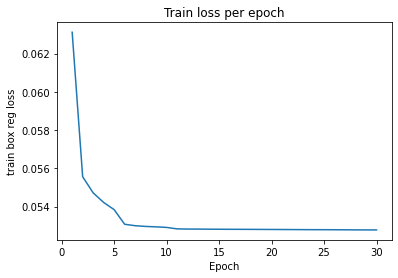

In [201]:
plt.plot(np.arange(1, 31),train_loss_all)
plt.title('Train loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('train box reg loss')
plt.show()

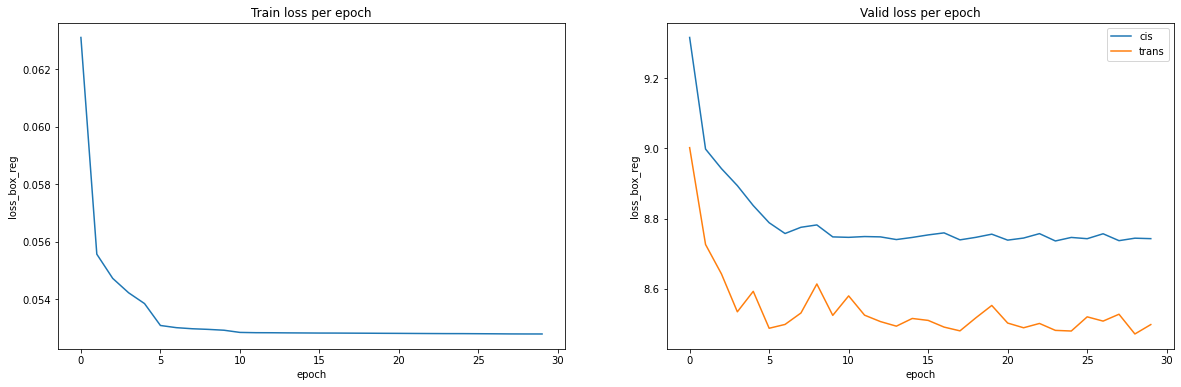

In [202]:
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(np.arange(num_epochs),train_loss_all,label='train')
ax[0].set_title('Train loss per epoch')
ax[0].set_ylabel('loss_box_reg')
ax[0].set_xlabel('epoch')

plt.title('Train loss per epoch')
ax[1].plot(np.arange(num_epochs),cis_loss_all, label='cis')
ax[1].plot(np.arange(num_epochs),trans_loss_all, label='trans')
ax[1].set_title('Valid loss per epoch')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')
ax[1].legend()

## Predictions

In [223]:
trans_valid_dataloader

In [247]:
train_features, train_labels = next(iter(trans_valid_dataloader))
image = list(image.to(device) for image in train_features)

model.eval()
with torch.no_grad():
      pred = model(image)

RuntimeError: CUDA out of memory. Tried to allocate 548.00 MiB (GPU 0; 11.00 GiB total capacity; 7.07 GiB already allocated; 0 bytes free; 9.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Text(0.5, 1.0, 'After NMS')

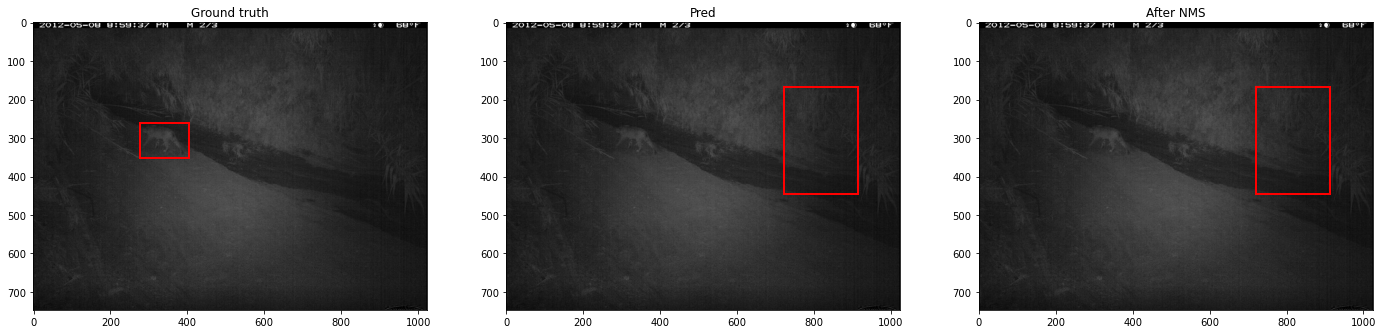

In [250]:
fig, ax = plt.subplots(1,3,figsize=(24,16))

ax[0].imshow(train_features[0][0].squeeze(),cmap="gray")
rect = patches.Rectangle((train_labels[0]['boxes'][0][0], 
                          train_labels[0]['boxes'][0][1]), 
                         train_labels[0]['boxes'][0][2]-train_labels[0]['boxes'][0][0], 
                         train_labels[0]['boxes'][0][3]-train_labels[0]['boxes'][0][1], 
                         linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)
ax[0].set_title('Ground truth')

ax[1].imshow(train_features[0][0].squeeze(),cmap="gray")
for i in range(len(pred[0]['boxes'])):
    rect = patches.Rectangle((pred[0]['boxes'][i][0].cpu(), 
                              pred[0]['boxes'][i][1].cpu()), 
                             (pred[0]['boxes'][i][2]-pred[0]['boxes'][i][0]).cpu(), 
                             (pred[0]['boxes'][i][3]-pred[0]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
ax[1].set_title('Pred')

#NMS
iou_threshold=0.005 # param to tune
boxes_to_keep=torchvision.ops.nms(pred[0]['boxes'],pred[0]['scores'],iou_threshold=iou_threshold).cpu()
ax[2].imshow(train_features[0][0].squeeze(),cmap="gray")
for i in boxes_to_keep:
    rect = patches.Rectangle((pred[0]['boxes'][i][0].cpu(), 
                              pred[0]['boxes'][i][1].cpu()), 
                             (pred[0]['boxes'][i][2]-pred[0]['boxes'][i][0]).cpu(), 
                             (pred[0]['boxes'][i][3]-pred[0]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[2].add_patch(rect)

ax[2].set_title('After NMS')


In [ ]:
# 'For evaluation, we consider a detected box to be correct if its IoU ≥ 0.5 with a ground truth box.'

### Metrics

In [206]:
metric = MeanAveragePrecision( max_detection_thresholds=[2])
metric.update(pred, list(train_labels))
from pprint import pprint
pprint(metric.compute())

{'map': tensor(-1.),
 'map_50': tensor(0.),
 'map_75': tensor(0.),
 'map_large': tensor(0.),
 'map_medium': tensor(0.),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_2': tensor(0.),
 'mar_2_per_class': tensor(-1.),
 'mar_large': tensor(0.),
 'mar_medium': tensor(0.),
 'mar_small': tensor(-1.)}
